# Feature Engineering Notebook

## Objectives
* 
*

## Inputs

*

## Outputs

*

## Conclusions
*

---

## Change working directory

We need to change the working directory from its current folder to its parent folder

* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/ames-heritage-housing/jupyter_notebooks'

We want to make the parent of the current directory the new current directory

* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/ames-heritage-housing'

## Load Cleaned Data

Loading the Train Set

In [4]:
import pandas as pd
train_set_path = "outputs/datasets/cleaned/TrainSetCleaned.csv"
TrainSet = pd.read_csv(train_set_path)
TrainSet.head(3)

1stFlrSF  2ndFlrSF  BedroomAbvGr BsmtExposure  BsmtFinSF1 BsmtFinType1  \
0      1828       0.0           3.0           Av          48          Unf   
1       894       0.0           2.0           No           0          Unf   
2       964       0.0           2.0           No         713          ALQ   

   BsmtUnfSF  GarageArea GarageFinish  GarageYrBlt  ...  LotArea LotFrontage  \
0       1774         774          Unf       2007.0  ...    11694        90.0   
1        894         308          Unf       1962.0  ...     6600        60.0   
2        163         432          Unf       1921.0  ...    13360        80.0   

   MasVnrArea  OpenPorchSF  OverallCond  OverallQual  TotalBsmtSF  YearBuilt  \
0       452.0          108            5            9         1822       2007   
1         0.0            0            5            5          894       1962   
2         0.0            0            7            5          876       1921   

   YearRemodAdd  SalePrice  
0          2007     314813  
1          1962     109500  
2          2006     163500  

[3 rows x 22 columns]

Loading the Test Set

In [5]:
test_set_path = "outputs/datasets/cleaned/TestSetCleaned.csv"
TestSet = pd.read_csv(test_set_path)
TestSet.head(3)

1stFlrSF  2ndFlrSF  BedroomAbvGr BsmtExposure  BsmtFinSF1 BsmtFinType1  \
0      2515       0.0           4.0           No        1219          Rec   
1       958     620.0           3.0           No         403          BLQ   
2       979     224.0           3.0           No         185          LwQ   

   BsmtUnfSF  GarageArea GarageFinish  GarageYrBlt  ...  LotArea LotFrontage  \
0        816         484          Unf       1975.0  ...    32668        69.0   
1        238         240          Unf       1941.0  ...     9490        79.0   
2        524         352          Unf       1950.0  ...     7015        69.0   

   MasVnrArea  OpenPorchSF  OverallCond  OverallQual  TotalBsmtSF  YearBuilt  \
0         0.0            0            3            6         2035       1957   
1         0.0            0            7            6          806       1941   
2       161.0            0            4            5          709       1950   

   YearRemodAdd  SalePrice  
0          1975     200624  
1          1950     133000  
2          1950     110000  

[3 rows x 22 columns]

## Data Exploration
* Pandas Profiling to investigation potential transformation in our data
- Categorical/ Text data - Ordinal Encoder to transform each class into numbers.
- If Categorical but numbered classes, these do not need to be transformed (no transformation required).


In [6]:
from ydata_profiling import ProfileReport

pandas_report = ProfileReport(df=TrainSet, minimal=True)
pandas_report.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Correlation and PPS Analysis of the Cleaned Data

As we have gone through an extensive steps in the data cleaning stage, it would be useful to check the correlation and PPS levels.

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ppscore as pps

def heatmap_corr(df, threshold, figsize=(20,12), font_annot=8):
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True
        mask[abs(df) < threshold] = True

        fig, axes = plt.subplots(figsize=figsize)
        sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                    mask=mask, cmap='viridis', annot_kws={"size": font_annot}, ax=axes, 
                    linewidth=0.5
                    )
        axes.set_yticklabels(df.columns, rotation=0)
        plt.ylim(len(df.columns), 0)
        plt.show()


def heatmap_pps(df, threshold, figsize=(20, 12), font_annot=8):
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=np.bool)
        mask[abs(df) < threshold] = True

        fig, ax = plt.subplots(figsize=figsize)
        ax = sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True, mask=mask,
                        cmap='rocket_r',
                        annot_kws={"size": font_annot}, linewidth=0.05, linecolor='grey')
        plt.ylim(len(df.columns), 0)
        plt.show()


def CalculateCorrAndPPS(df):
    df_corr_spearman = df.corr(method="spearman")
    df_corr_pearson = df.corr(method="pearson")

    pps_matrix_raw = pps.matrix(df)
    pps_matrix = pps_matrix_raw.filter(['x', 'y', 'ppscore']).pivot(columns='x', index='y', values='ppscore')

    pps_score_stats = pps_matrix_raw.query("ppscore < 1").filter(['ppscore']).describe().T
    print("PPS theshold - check PPS score IQR to decide threshold for heatmap \n")
    print(pps_score_stats.round(3))

    return df_corr_pearson, df_corr_spearman, pps_matrix

def DisplayCorrAndPPS(df_corr_pearson, df_corr_spearman, pps_matrix, CorrThreshold, PPS_Threshold,
                      figsize=(20, 12), font_annot=8):
    
    print("\n")
    print("* Analyse how the target variable for your ML models are correlated with other variables (features and target)")
    print("* Analyse multi-colinearity, that is, how the features are correlated among themselves")

    print("\n")
    print("*** Heatmap: Spearman Correlation ***")
    print("It evaluates monotonic relationship \n")
    heatmap_corr(df=df_corr_spearman, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Pearson Correlation ***")
    print("It evaluates the linear relationship between two continuous variables \n")
    heatmap_corr(df=df_corr_pearson, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Power Predictive Score (PPS) ***")
    print(f"PPS detects linear or non-linear relationships between two columns.\n"
         f"The score ranges from 0 (no predictive power) to 1 (perfect predictive power) \n")
    heatmap_pps(df=pps_matrix, threshold=PPS_Threshold, figsize=figsize, font_annot=font_annot)

Then we use CalculateCorrAndPPS to calculate Correlations and Power Predictive Score

In [9]:
df_corr_pearson, df_corr_spearman, pps_matrix = CalculateCorrAndPPS(TrainSet)

PPS theshold - check PPS score IQR to decide threshold for heatmap 

         count   mean    std  min  25%  50%    75%    max
ppscore  462.0  0.059  0.105  0.0  0.0  0.0  0.075  0.618




* Analyse how the target variable for your ML models are correlated with other variables (features and target)
* Analyse multi-colinearity, that is, how the features are correlated among themselves


*** Heatmap: Spearman Correlation ***
It evaluates monotonic relationship 



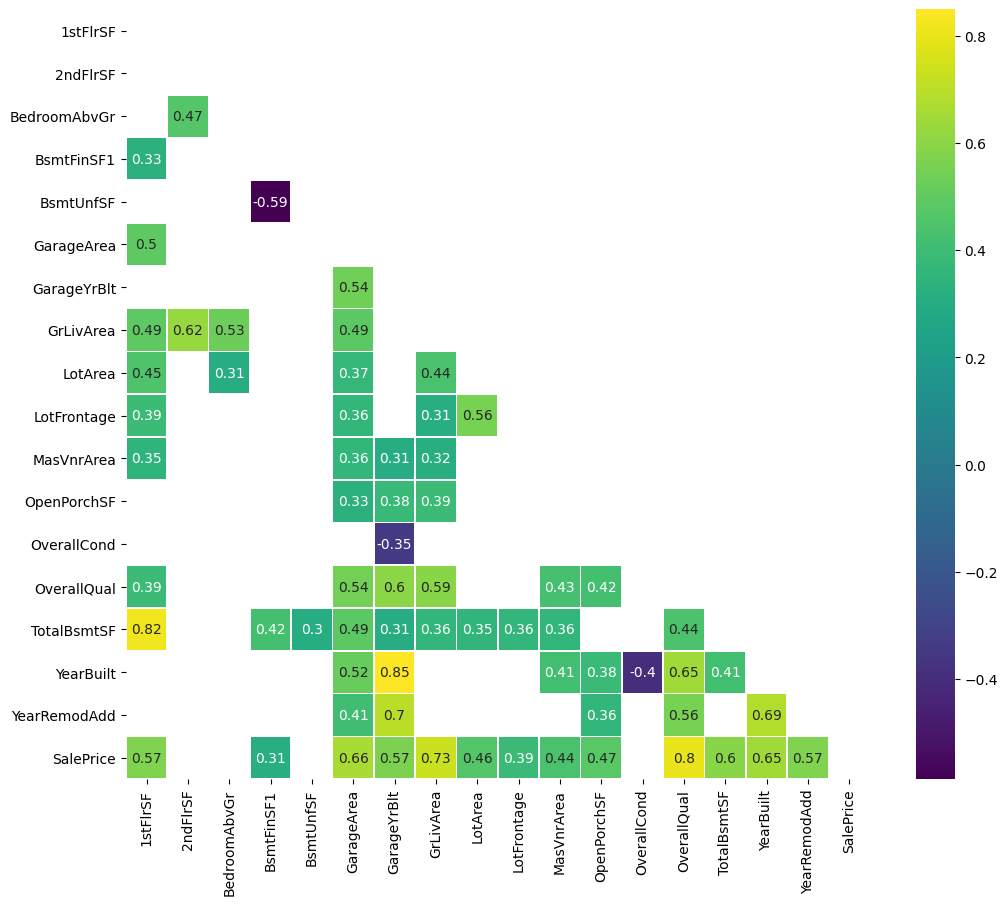



*** Heatmap: Pearson Correlation ***
It evaluates the linear relationship between two continuous variables 



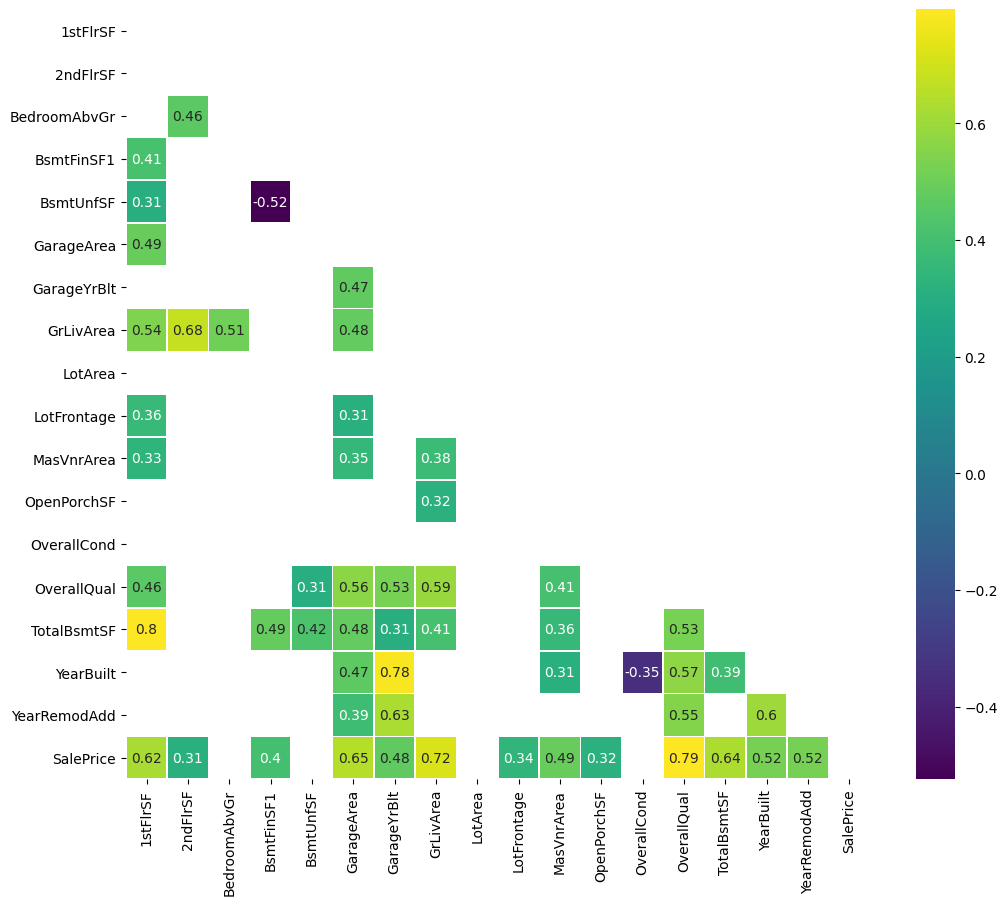



*** Heatmap: Power Predictive Score (PPS) ***
PPS detects linear or non-linear relationships between two columns.
The score ranges from 0 (no predictive power) to 1 (perfect predictive power) 



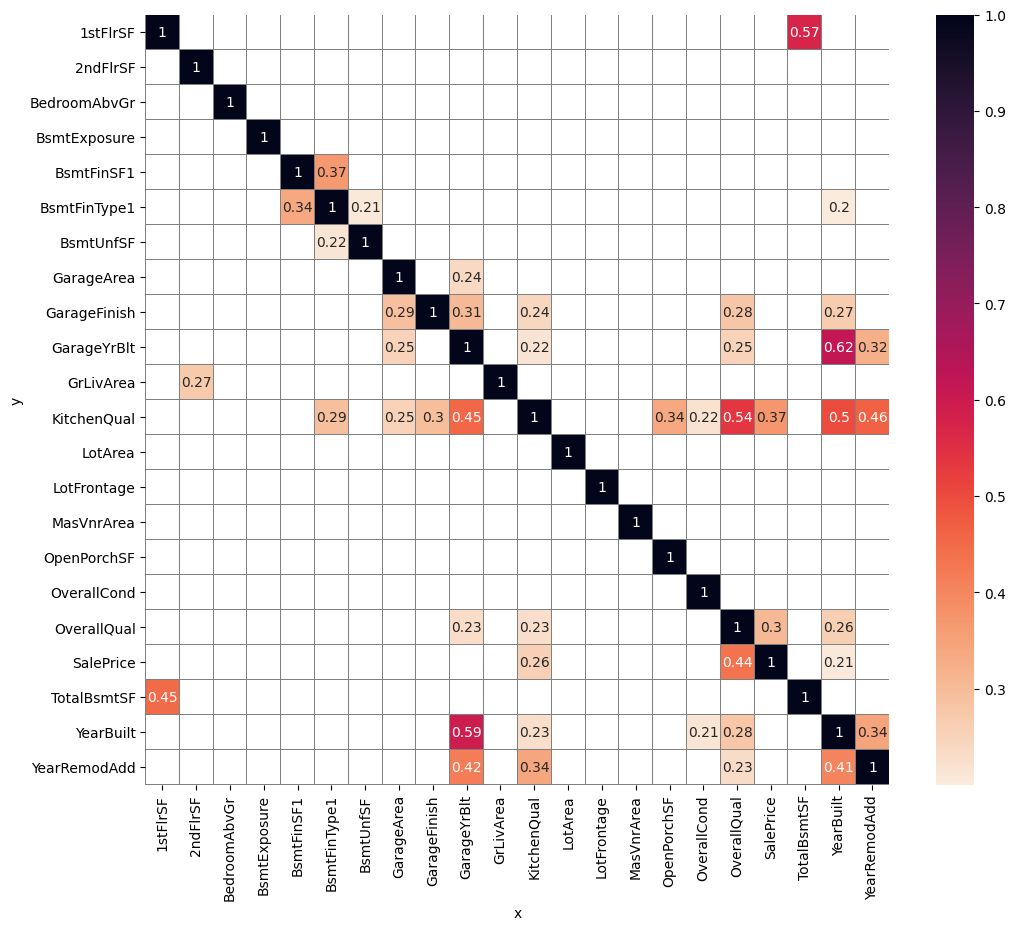

In [10]:
DisplayCorrAndPPS(df_corr_pearson = df_corr_pearson,
                    df_corr_spearman = df_corr_spearman,
                    pps_matrix = pps_matrix,
                    CorrThreshold = 0.3, PPS_Threshold = 0.2,
                    figsize=(12,10), font_annot = 10)

## Feature Engineering

### Custom Function
* We will use the custom function shown in the Feature Engineering section in the CI walkthrough.
* This will allow us to assess which feature engineering techniques to use.

In [11]:
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
from feature_engine import transformation as vt
from feature_engine.outliers import Winsorizer
from feature_engine.encoding import OrdinalEncoder
sns.set(style="whitegrid")
warnings.filterwarnings('ignore')


def FeatureEngineeringAnalysis(df, analysis_type=None):
    """
    - Used for quick feature engineering on numerical and categorical variables
    to decide which transformation can better transform the distribution shape
    - Once transformed, use a reporting tool, like pandas-profiling, to evaluate distrbutions
    """
    check_missing_values(df)
    allowed_types = ['numerical', 'ordinal_encoder', 'outlier_winsorizer']
    check_user_entry_on_analysis_type(analysis_type, allowed_types)
    list_column_transformers = define_list_column_transformers(analysis_type)

    # Loop over each variable and engineer the data according to the analysis type
    df_feat_eng = pd.DataFrame([])
    for column in df.columns:
        # create additional columns (column_method) to apply the methods
        df_feat_eng = pd.concat([df_feat_eng, df[column]], axis=1)
        for method in list_column_transformers:
            df_feat_eng[f"{column}_{method}"] = df[column]

        # Apply transformers in respectives column_transformers
        df_feat_eng, list_applied_transformers = apply_transformers(analysis_type, df_feat_eng, column)
        # For each variable, assess how the transformations perform
        transformer_evaluation(column, list_applied_transformers, analysis_type, df_feat_eng)
        
    return df_feat_eng

def check_user_entry_on_analysis_type(analysis_type, allowed_types):
    """ Check analysis type """
    if analysis_type is None:
        raise SystemExit(f"You should pass analysis_type parameter as one of the following options: {allowed_types}")
    if analysis_type not in allowed_types:
        raise SystemExit(f"analysis_type argument should be one of these options: {allowed_types}")

def check_missing_values(df):
    if df.isna().sum().sum() != 0:
        raise SystemExit(f"There is missing values in your dataset. Please handle that before getting into feature engineering.")

def define_list_column_transformers(analysis_type):
    """ Set suffix columns according to analysis_type """
    if analysis_type == 'numerical':
        list_column_transformers = ["log_e", "log_10", "reciprocal", "power", "box_cox", "yeo_johnson"]

    elif analysis_type == 'ordinal_encoder':
        list_column_transformers = ["ordinal_encoder"]

    elif analysis_type == 'outlier_winsorizer':
        list_column_transformers = ['iqr']
    
    return list_column_transformers

def apply_transformers(analysis_type, df_feat_eng, column):
    for col in df_feat_eng.select_dtypes(include='category').columns:
        df_feat_eng[col] = df_feat_eng[col].astype('object')
    
    if analysis_type == 'numerical':
        df_feat_eng, list_applied_transformers = FeatEngineering_Numerical(df_feat_eng, column)
        
    elif analysis_type == 'outlier_winsorizer':
        df_feat_eng, list_applied_transformers = FeatEngineering_OutlierWinsorizer(df_feat_eng, column)
    
    elif analysis_type == 'ordinal_encoder':
        df_feat_eng, list_applied_transformers = FeatEngineering_CategoricalEncoder(df_feat_eng, column)

    return df_feat_eng, list_applied_transformers

def transformer_evaluation(column, list_applied_transformers, analysis_type, df_feat_eng):
    # For each variable, assess how the transformations perform
    print(f"* Variable Analysed: {column}")
    print(f"* Transformation Applied: {list_applied_transformers} \n")
    for col in [column] + list_applied_transformers:

        if analysis_type != 'ordinal_encoder':
            DiagnosticPlots_Numerical(df_feat_eng, col)

        else:
            if col == column:
                DiagnosticPlots_Categories(df_feat_eng, col)
            else:
                DiagnosticPlots_Numerical(df_feat_eng, col)
        
        print("\n")

def DiagnosticPlots_Categories(df_feat_eng, col):
    plt.figure(figsize=(4,3))
    sns.countplot(data=df_feat_eng, x=col, palette=['#432371'], order=df_feat_eng[col].value_counts().index)
    plt.xticks(rotation=90)
    plt.suptitle(f"{col}", fontsize=30, y=1.05)
    plt.show()
    print("\n")

def DiagnosticPlots_Numerical(df, variable):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    sns.histplot(data=df, x=variable, kde=True, element="step", ax=axes[0])
    stats.probplot(df[variable], dist="norm", plot=axes[1])
    sns.boxplot(x=df[variable], ax=axes[2])

    axes[0].set_title('Histogram')
    axes[1].set_title('QQ Plot')
    axes[2].set_title('Boxplot')
    fig.suptitle(f"{variable}", fontsize=30, y=1.05)
    plt.tight_layout()
    plt.show()

def FeatEngineering_CategoricalEncoder(df_feat_eng, column):
    list_methods_worked = []
    try:
        encoder = OrdinalEncoder(encoding_method='arbitrary', variables=[f"{column}_ordinal_encoder"])
        df_feat_eng = encoder.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_ordinal_encoder")
    except Exception:
        df_feat_eng.drop([f"{column}_ordinal_encoder"], axis=1, inplace=True)
        
    return df_feat_eng, list_methods_worked

def FeatEngineering_OutlierWinsorizer(df_feat_eng, column):
    list_methods_worked = []

    # Winsorizer iqr
    try:
        disc = Winsorizer(
            capping_method='iqr', tail='both', fold=1.5, variables=[f"{column}_iqr"])
        df_feat_eng = disc.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_iqr")
    except Exception:
        df_feat_eng.drop([f"{column}_iqr"], axis=1, inplace=True)
    
    return df_feat_eng, list_methods_worked

def FeatEngineering_Numerical(df_feat_eng, column):
    list_methods_worked = []

    # LogTransformer base e
    try:
        lt = vt.LogTransformer(variables=[f"{column}_log_e"])
        df_feat_eng = lt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_log_e")
    except Exception:
        df_feat_eng.drop([f"{column}_log_e"], axis=1, inplace=True)

    # LogTransformer base 10
    try:
        lt = vt.LogTransformer(variables=[f"{column}_log_10"], base='10')
        df_feat_eng = lt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_log_10")
    except Exception:
        df_feat_eng.drop([f"{column}_log_10"], axis=1, inplace=True)

    # ReciprocalTransformer
    try:
        rt = vt.ReciprocalTransformer(variables=[f"{column}_reciprocal"])
        df_feat_eng = rt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_reciprocal")
    except Exception:
        df_feat_eng.drop([f"{column}_reciprocal"], axis=1, inplace=True)
    
    # PowerTransformer
    try:
        pt = vt.PowerTransformer(variables=[f"{column}_power"])
        df_feat_eng = pt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_power")
    except Exception:
        df_feat_eng.drop([f"{column}_power"], axis=1, inplace=True)
    
    # BoxCoxTransformer
    try:
        bct = vt.BoxCoxTransformer(variables=[f"{column}_box_cox"])
        df_feat_eng = bct.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_box_cox")
    except Exception:
        df_feat_eng.drop([f"{column}_box_cox"], axis=1, inplace=True)
    
    ### YeoJohnsonTransformer
    try:
        yjt = vt.YeoJohnsonTransformer(variables=[f"{column}_yeo_johnson"])
        df_feat_eng = yjt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_yeo_johnson")
    except Exception:
        df_feat_eng.drop([f"{column}_yeo_johnson"], axis=1, inplace=True)
        
    return df_feat_eng, list_methods_worked

## Feature Engineering Summary

The transformers that we will use are:
* Categorical Encoding
* Numerical Transformations
* Outlier Winsorizer
* Smart Correlation Selection

The steps we will use for each will be as follows:
* Step 1: Select variables
* Step 2: Create separate DataFrame
* Step 3: Create engineered variable applying the transformations, assess the variables distribution and select suitable method
* Step 4: Apply the selected transformation to the Train and Test set

### Categorical Encoding

Step 1: Categorical Encoding - Ordinal: replaces categories by ordinal numbers

In [12]:
variables_engineering = ['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual']
variables_engineering

['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual']

Step 2: Create a separate DataFrame, with the variable(s)

In [13]:
df_engineering = TrainSet[variables_engineering].copy()
df_engineering.head(3)

BsmtExposure BsmtFinType1 GarageFinish KitchenQual
0           Av          Unf          Unf          Gd
1           No          Unf          Unf          TA
2           No          ALQ          Unf          TA

Step 3: Create engineered variable(s) applying the transformation(s), assess engineered variables distribution and select most suitable method for each variable

* Variable Analysed: BsmtExposure
* Transformation Applied: ['BsmtExposure_ordinal_encoder'] 



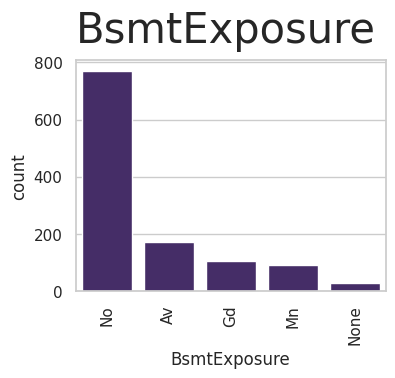

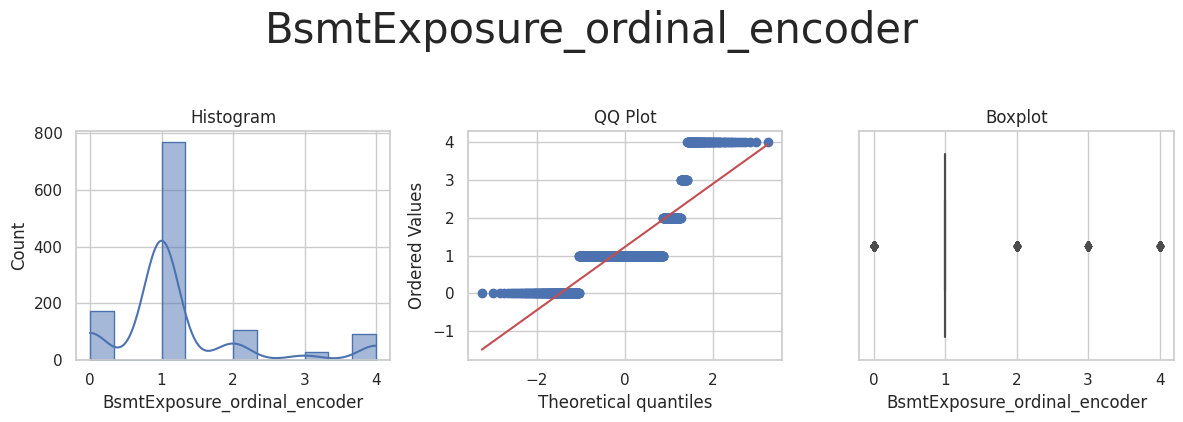



* Variable Analysed: BsmtFinType1
* Transformation Applied: ['BsmtFinType1_ordinal_encoder'] 



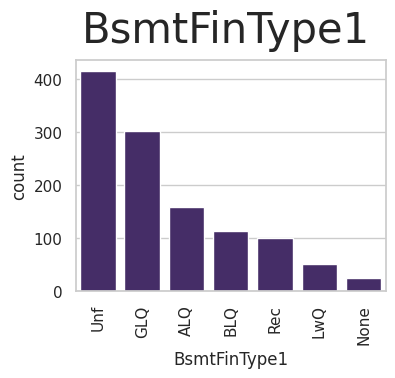

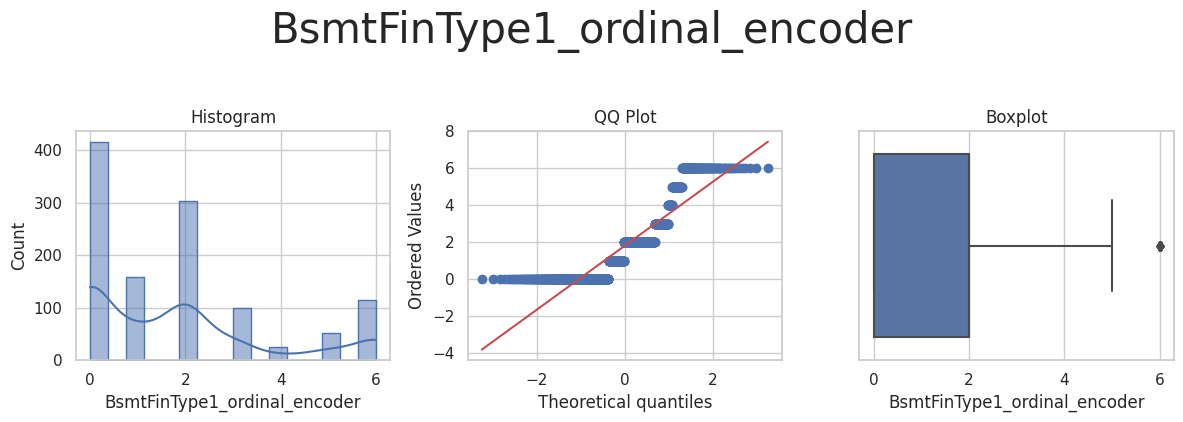



* Variable Analysed: GarageFinish
* Transformation Applied: ['GarageFinish_ordinal_encoder'] 



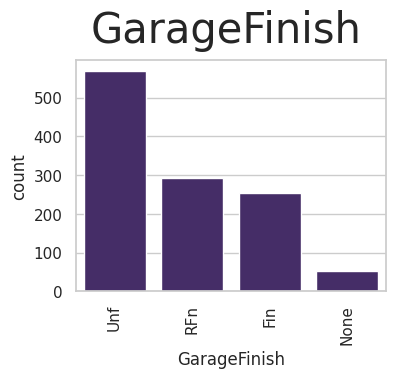

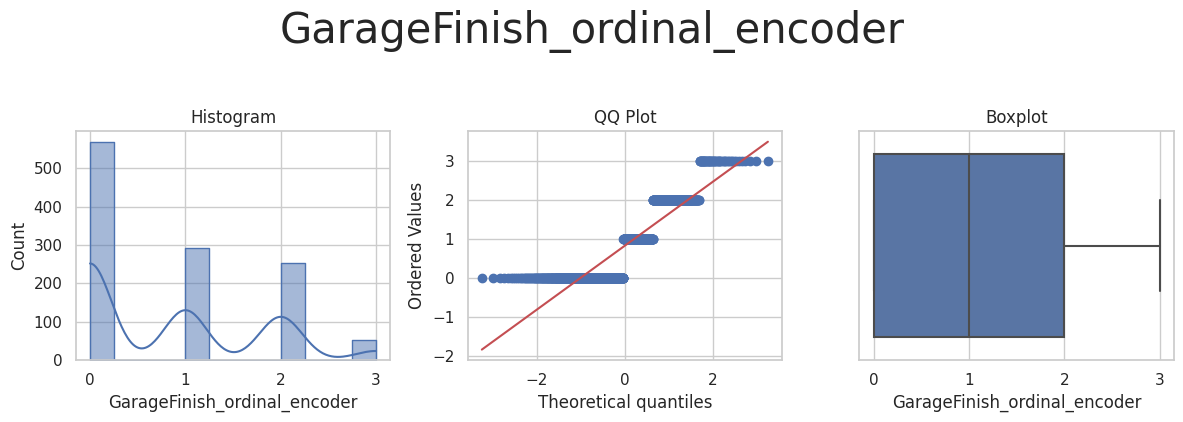



* Variable Analysed: KitchenQual
* Transformation Applied: ['KitchenQual_ordinal_encoder'] 



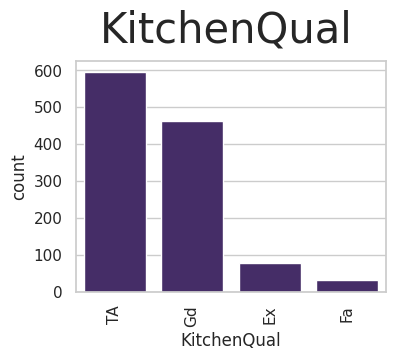

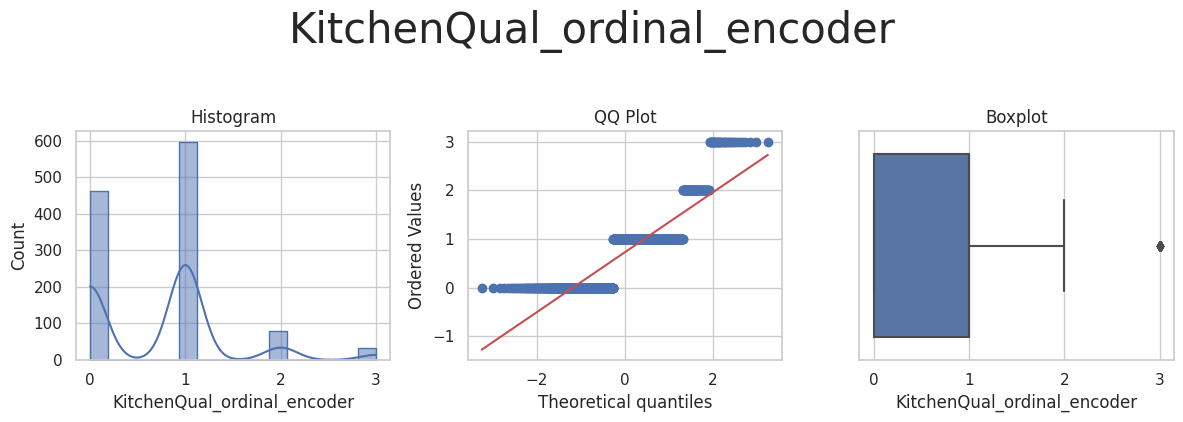

In [14]:
df_engineering = FeatureEngineeringAnalysis(df=df_engineering, analysis_type='ordinal_encoder')

Findings: for each variable on how the transformation(s), look(s) to be effective

* The data is skewed and does not show symmetric distibution.
* For all categorical variables, the transformation is effective, since it converts categories to numbers.

Step 4: Apply the selected transformation to the Train and Test set

In [15]:
encoder = OrdinalEncoder(encoding_method='arbitrary', variables=variables_engineering)
TrainSet = encoder.fit_transform(TrainSet)
TestSet = encoder.transform(TestSet)

print("* Categorical encoding - ordinal transformation done!")

* Categorical encoding - ordinal transformation done!


### Numerical Transformation

Step 1: Select variables

In [16]:
variables_engineering = ['1stFlrSF', '2ndFlrSF', 'BsmtFinSF1',
                        'BsmtUnfSF', 'TotalBsmtSF', 'GarageArea',
                         'GrLivArea', 'LotArea', 'LotFrontage',
                          'MasVnrArea', 'OpenPorchSF']

variables_engineering

['1stFlrSF',
 '2ndFlrSF',
 'BsmtFinSF1',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'GarageArea',
 'GrLivArea',
 'LotArea',
 'LotFrontage',
 'MasVnrArea',
 'OpenPorchSF']

Step 2: Create separate DataFrame

In [17]:
df_engineering = TrainSet[variables_engineering].copy()
df_engineering.head(3)

1stFlrSF  2ndFlrSF  BsmtFinSF1  BsmtUnfSF  TotalBsmtSF  GarageArea  \
0      1828       0.0          48       1774         1822         774   
1       894       0.0           0        894          894         308   
2       964       0.0         713        163          876         432   

   GrLivArea  LotArea  LotFrontage  MasVnrArea  OpenPorchSF  
0       1828    11694         90.0       452.0          108  
1        894     6600         60.0         0.0            0  
2        964    13360         80.0         0.0            0

Step 3: Create engineered variable applying the transformations, assess the variables distribution and select suitable method

* Variable Analysed: 1stFlrSF
* Transformation Applied: ['1stFlrSF_log_e', '1stFlrSF_log_10', '1stFlrSF_reciprocal', '1stFlrSF_power', '1stFlrSF_box_cox', '1stFlrSF_yeo_johnson'] 



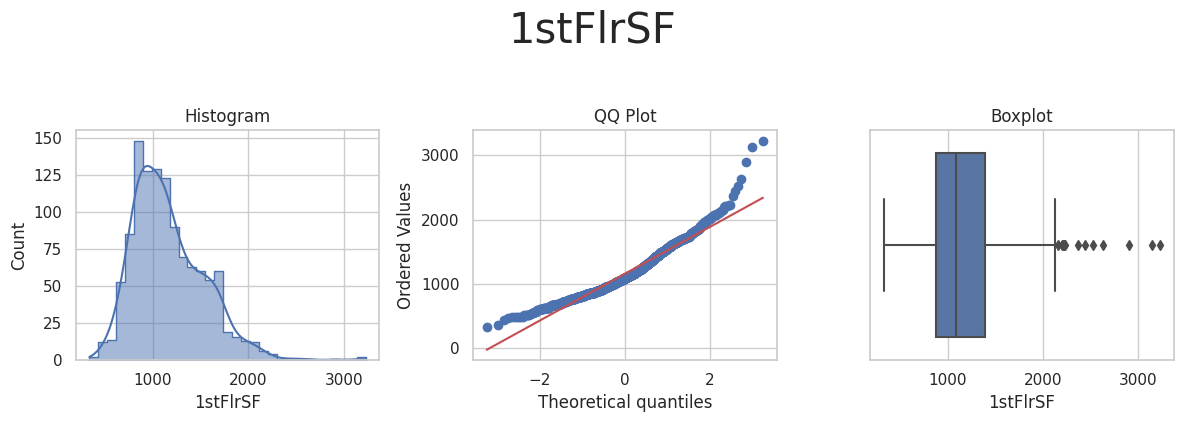

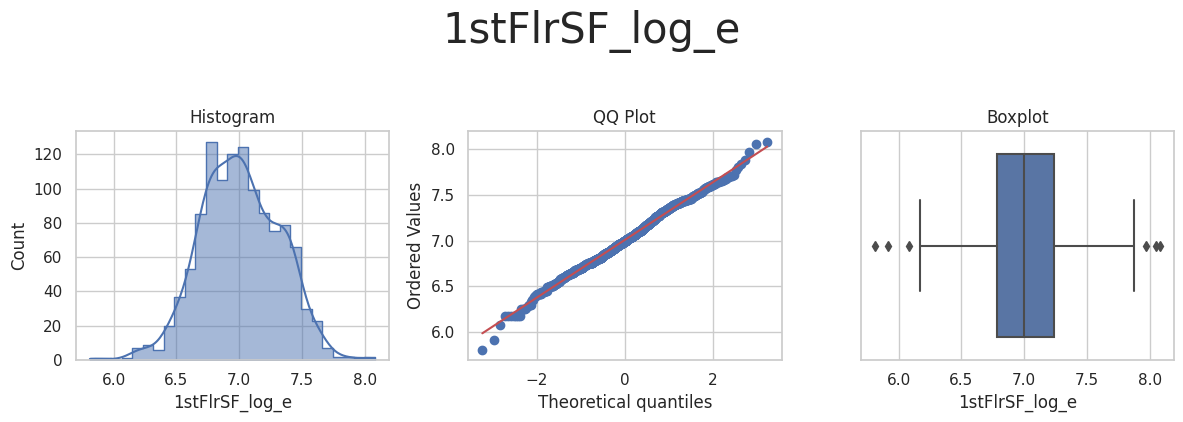

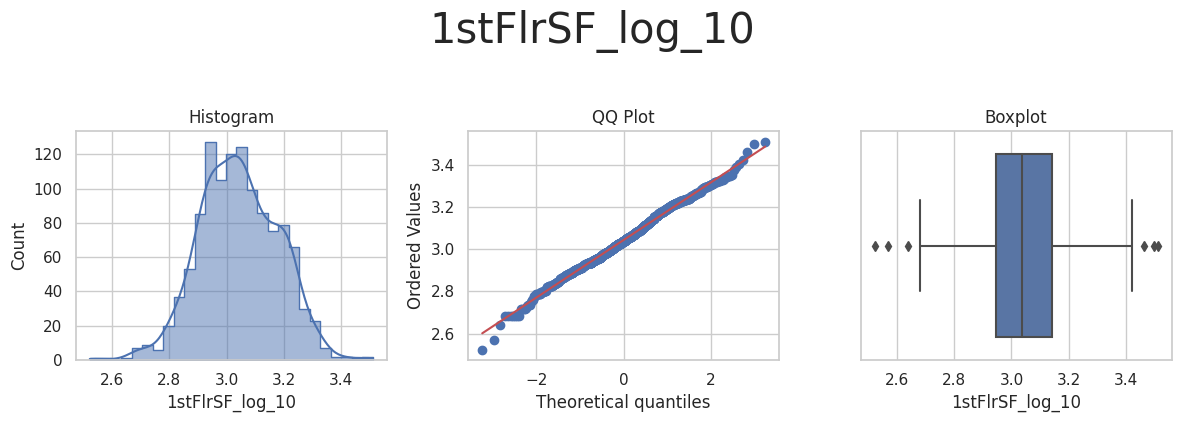

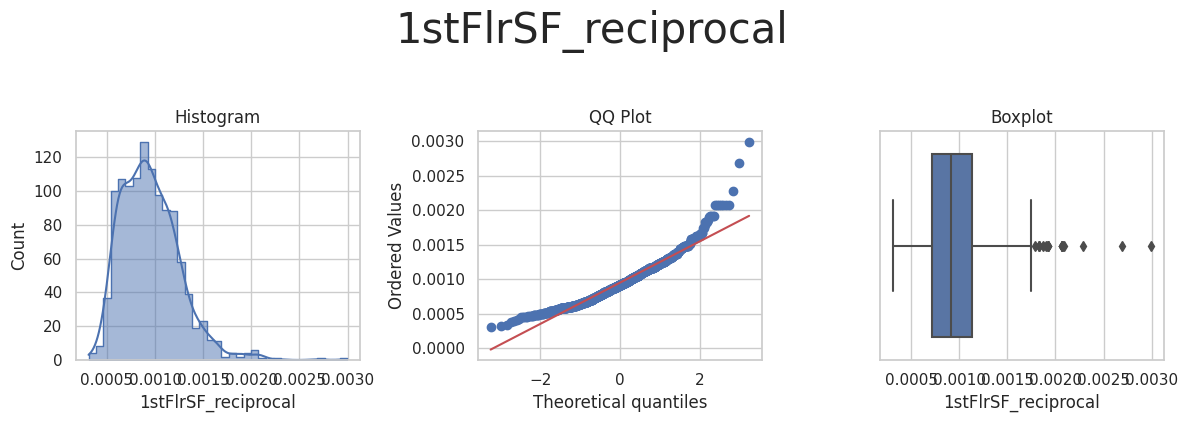

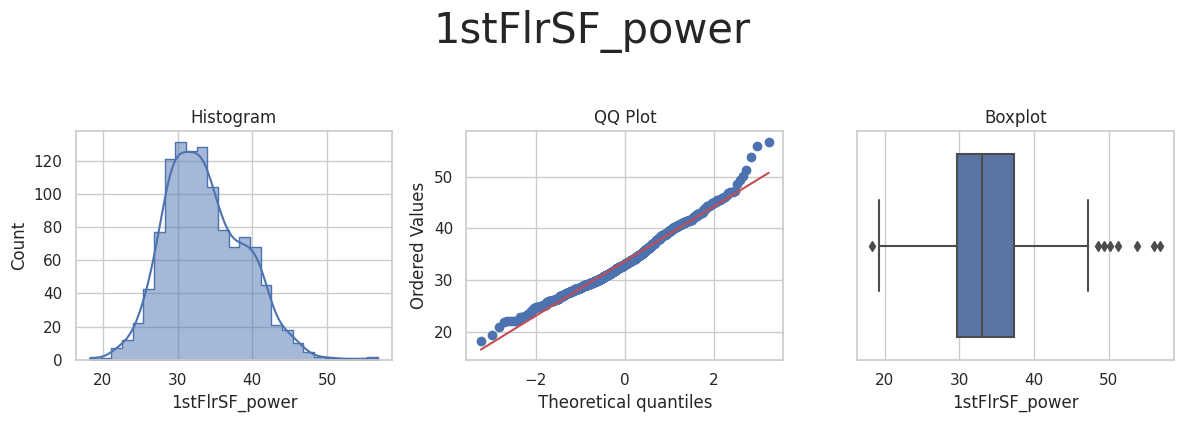

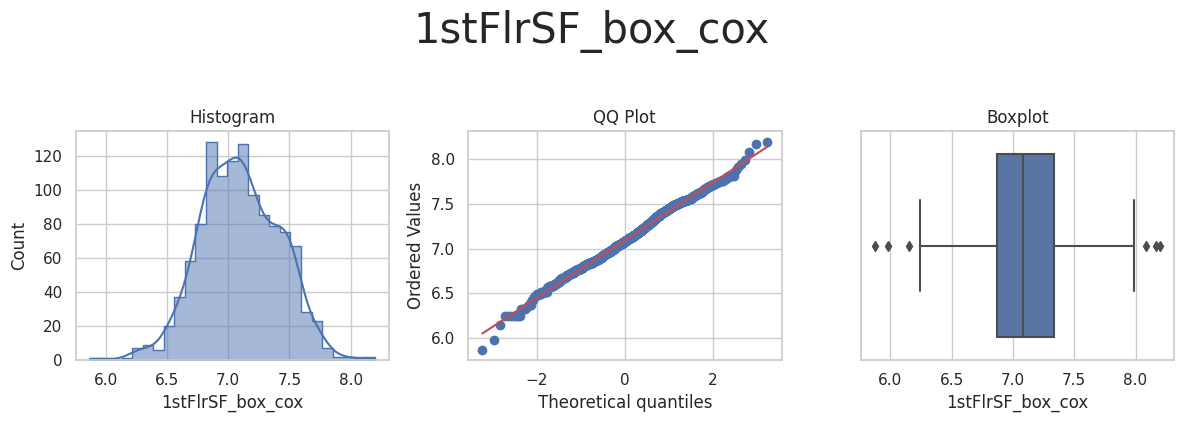

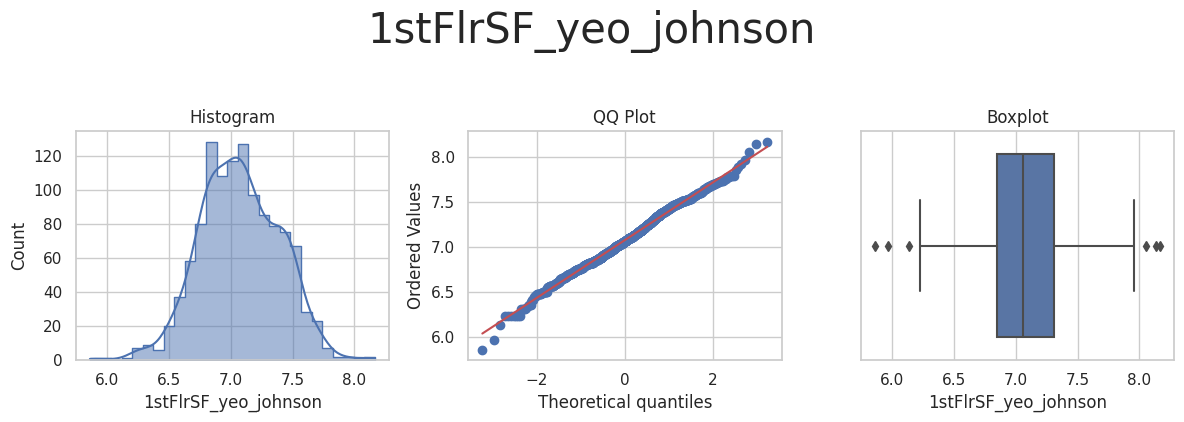



* Variable Analysed: 2ndFlrSF
* Transformation Applied: ['2ndFlrSF_power', '2ndFlrSF_yeo_johnson'] 



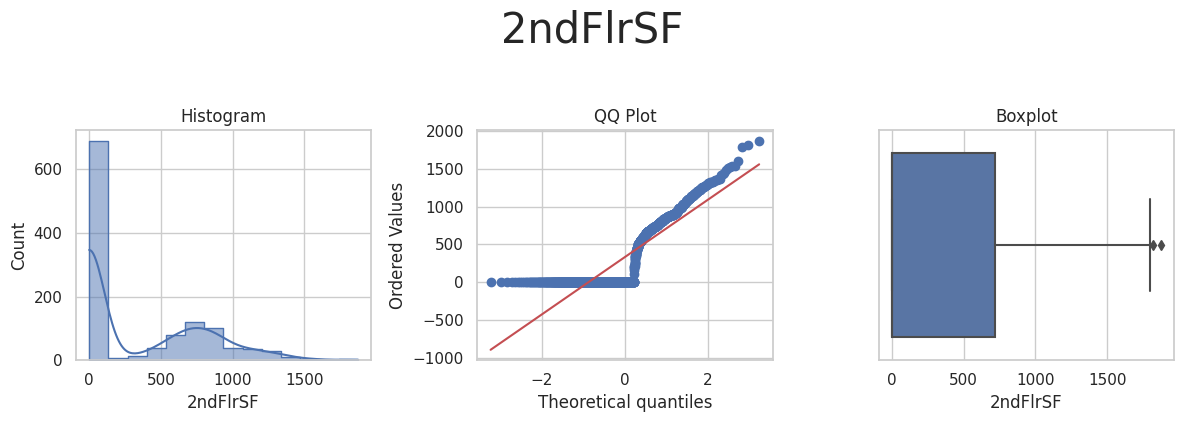

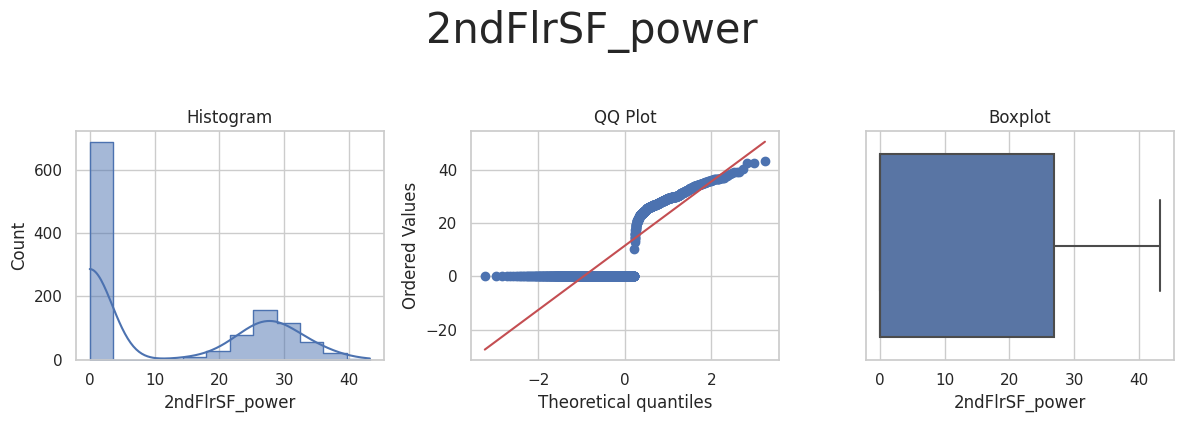

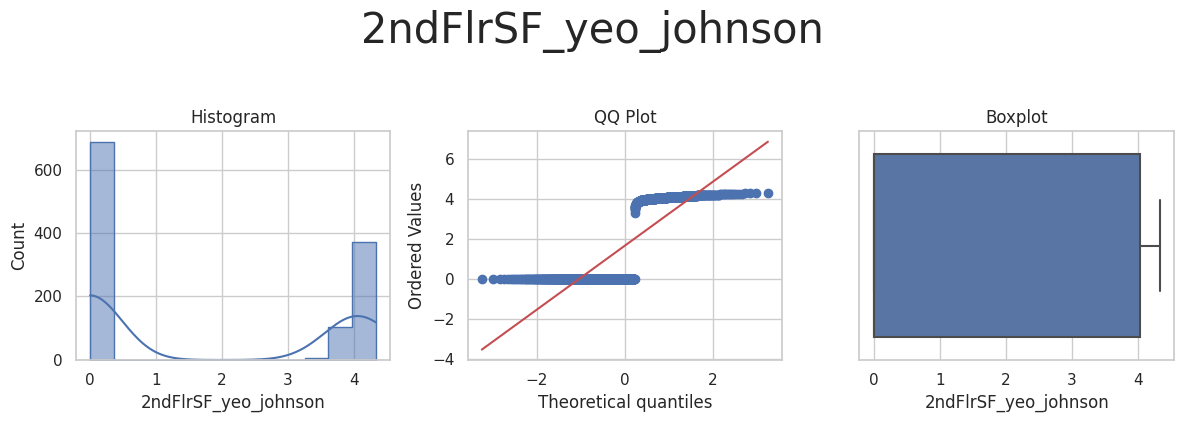



* Variable Analysed: BsmtFinSF1
* Transformation Applied: ['BsmtFinSF1_power', 'BsmtFinSF1_yeo_johnson'] 



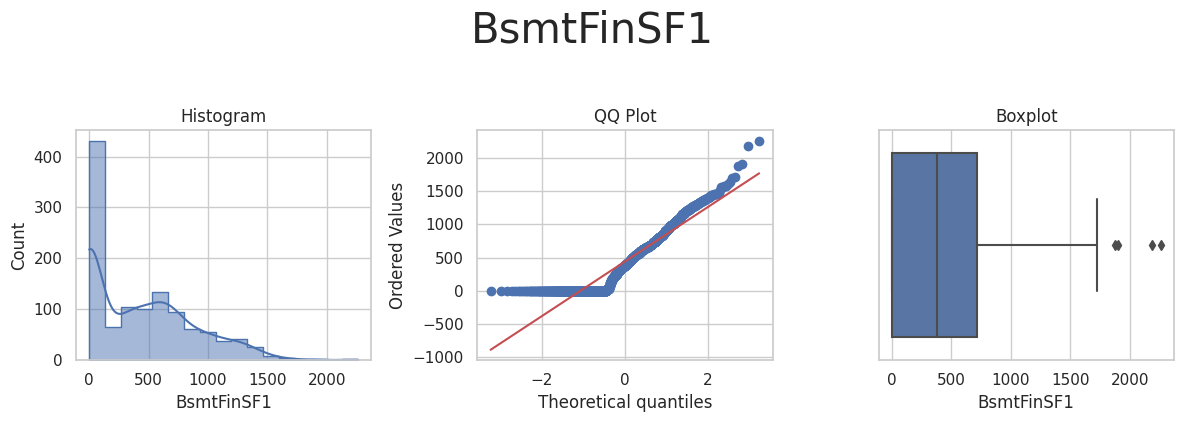

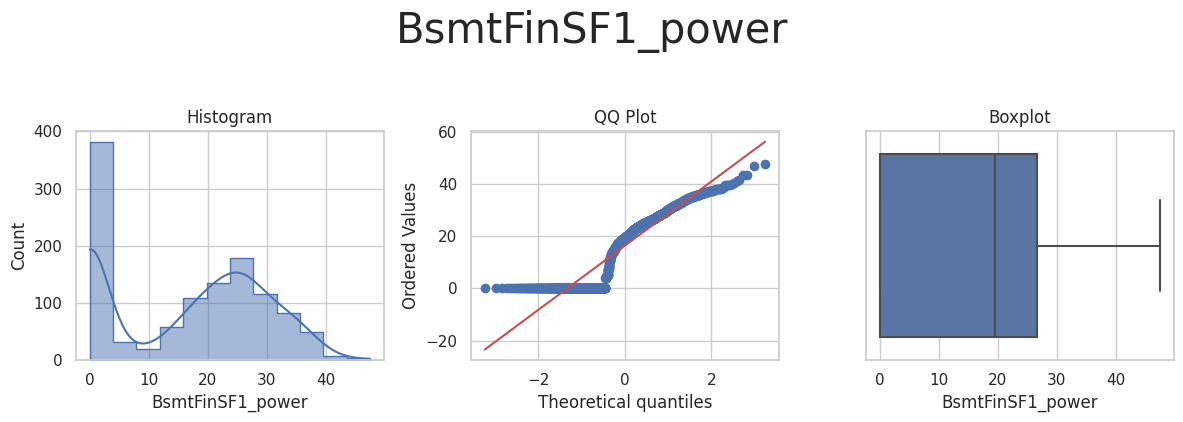

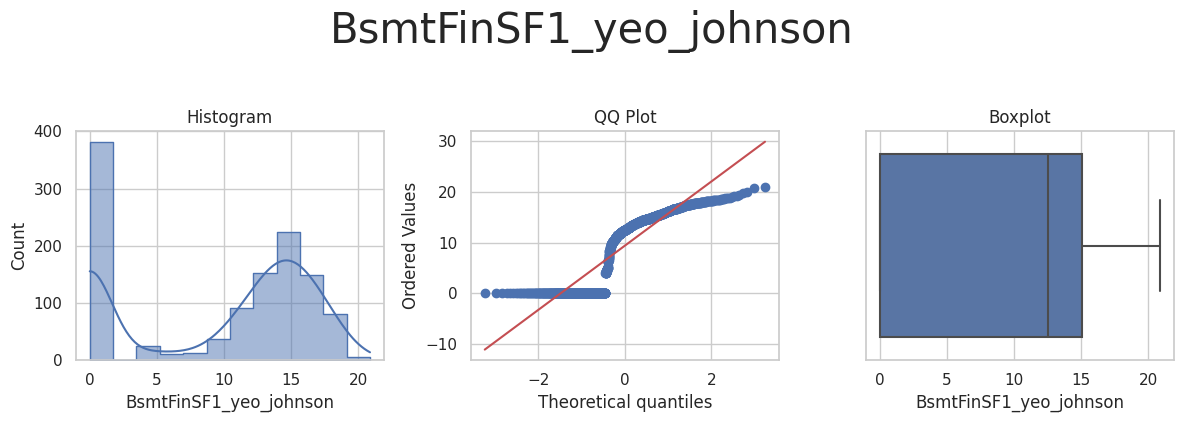



* Variable Analysed: BsmtUnfSF
* Transformation Applied: ['BsmtUnfSF_power', 'BsmtUnfSF_yeo_johnson'] 



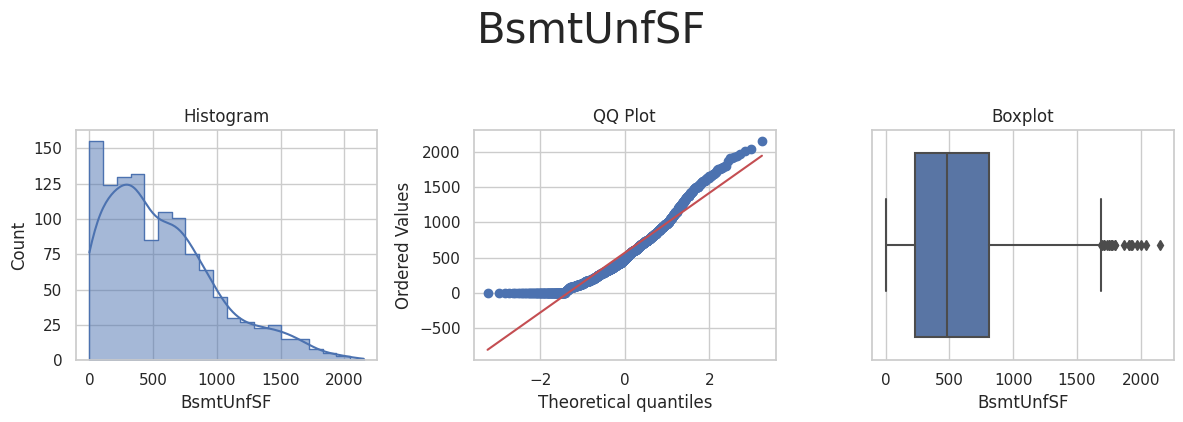

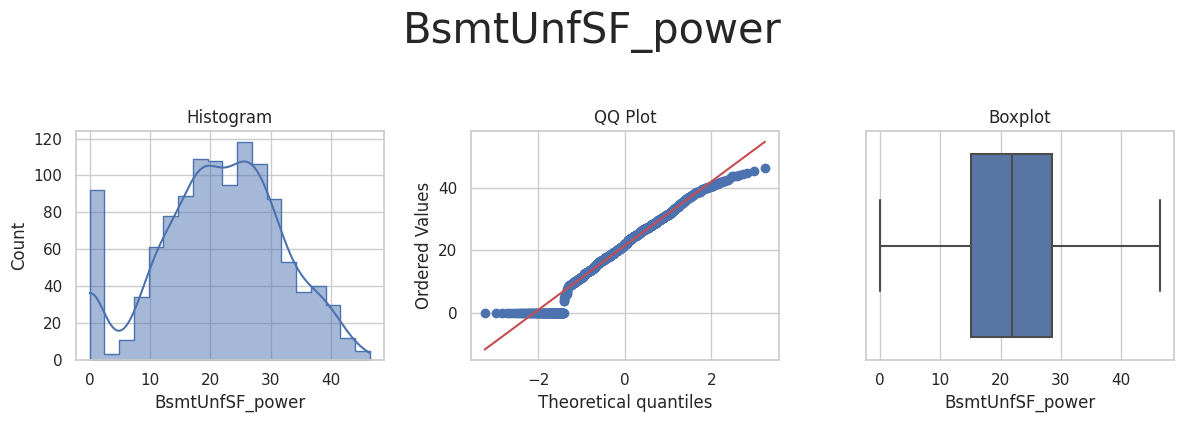

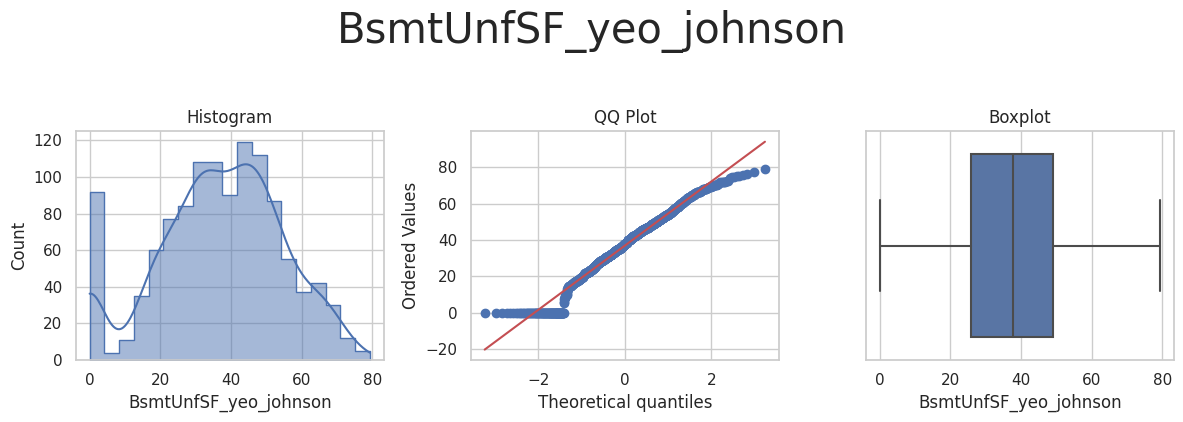



* Variable Analysed: TotalBsmtSF
* Transformation Applied: ['TotalBsmtSF_power', 'TotalBsmtSF_yeo_johnson'] 



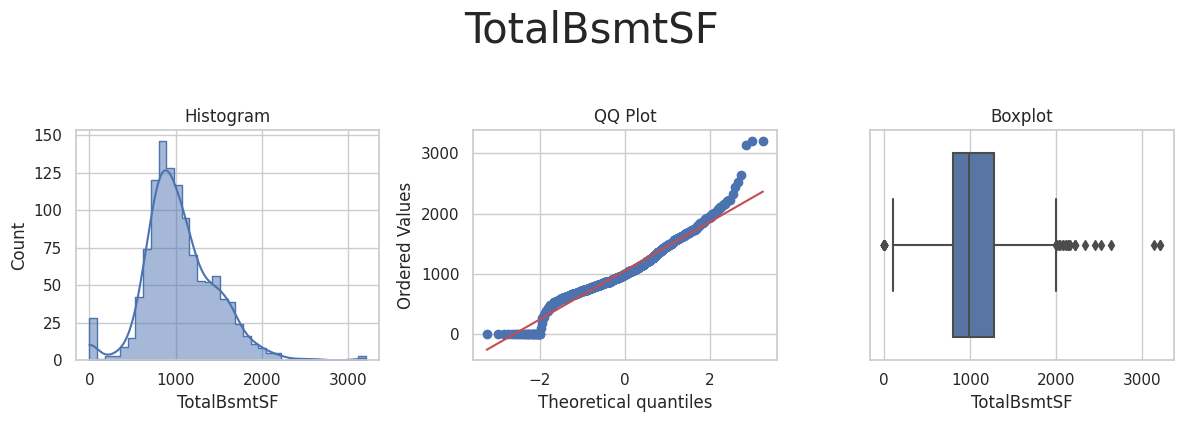

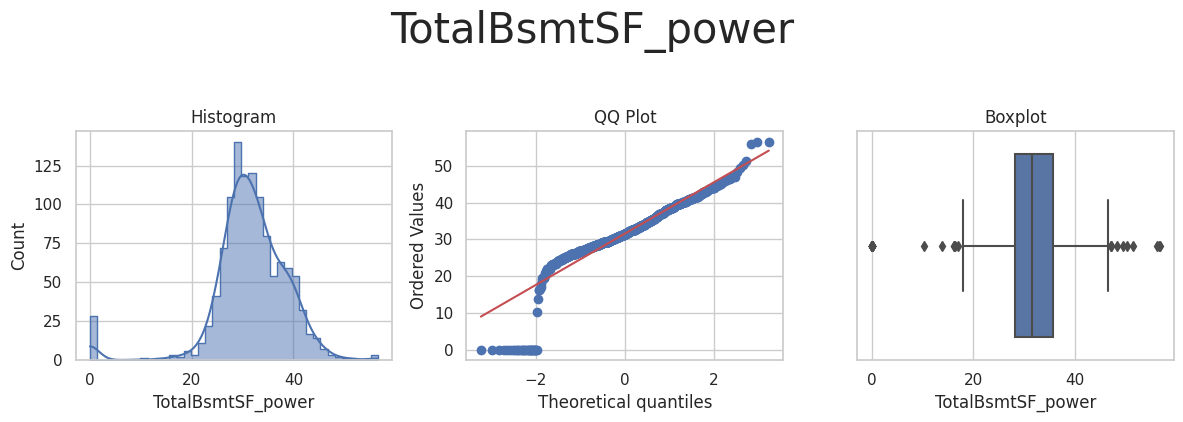

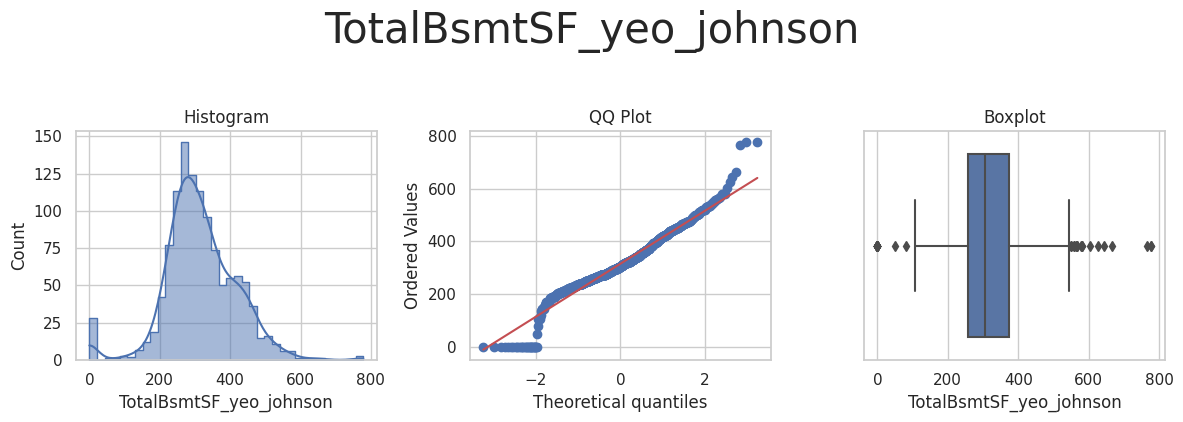



* Variable Analysed: GarageArea
* Transformation Applied: ['GarageArea_power', 'GarageArea_yeo_johnson'] 



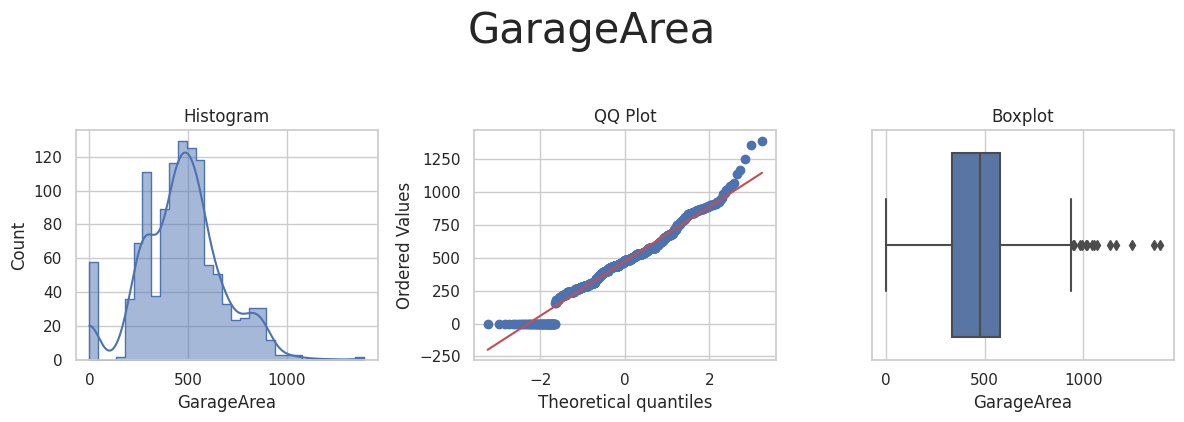

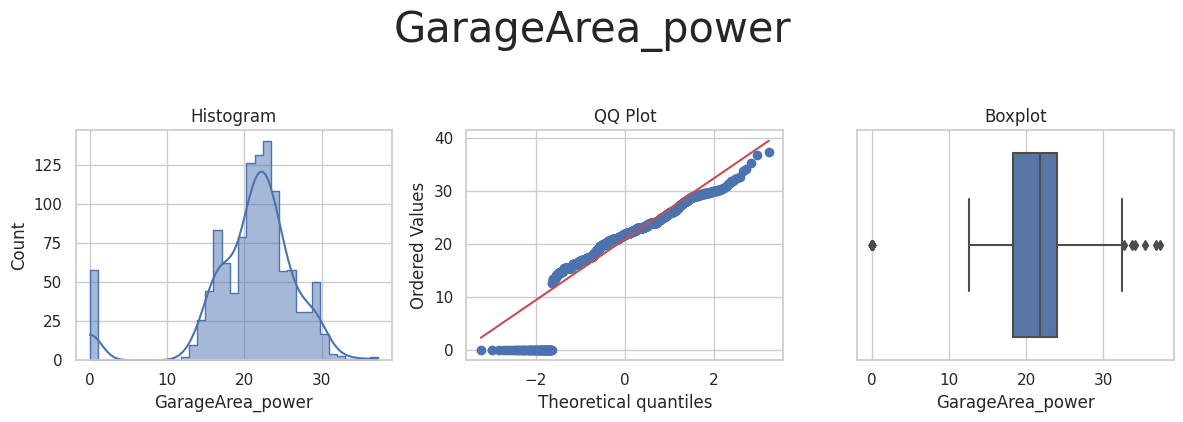

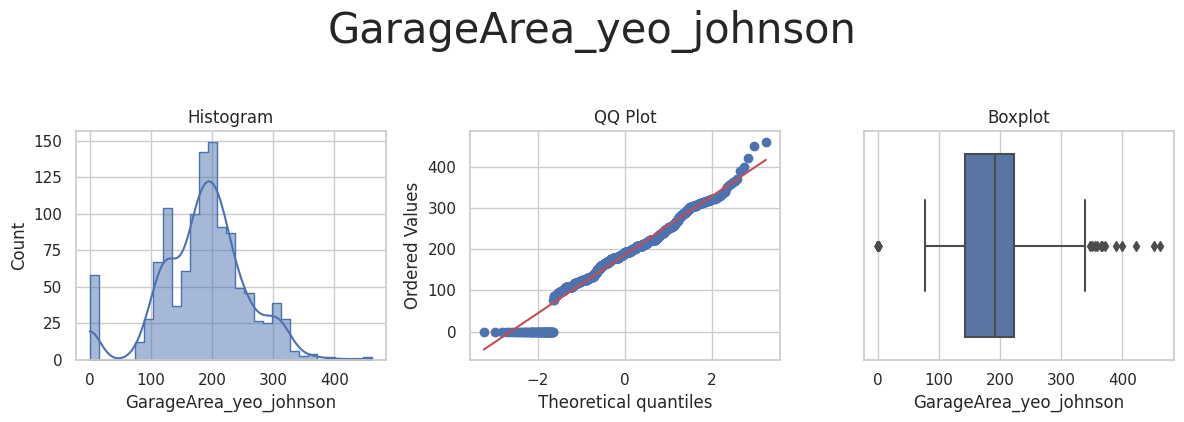



* Variable Analysed: GrLivArea
* Transformation Applied: ['GrLivArea_log_e', 'GrLivArea_log_10', 'GrLivArea_reciprocal', 'GrLivArea_power', 'GrLivArea_box_cox', 'GrLivArea_yeo_johnson'] 



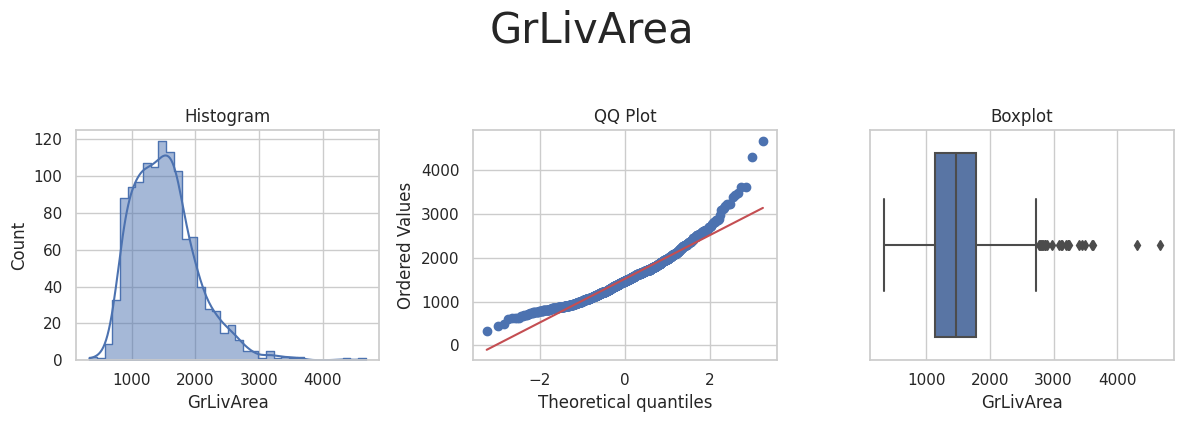

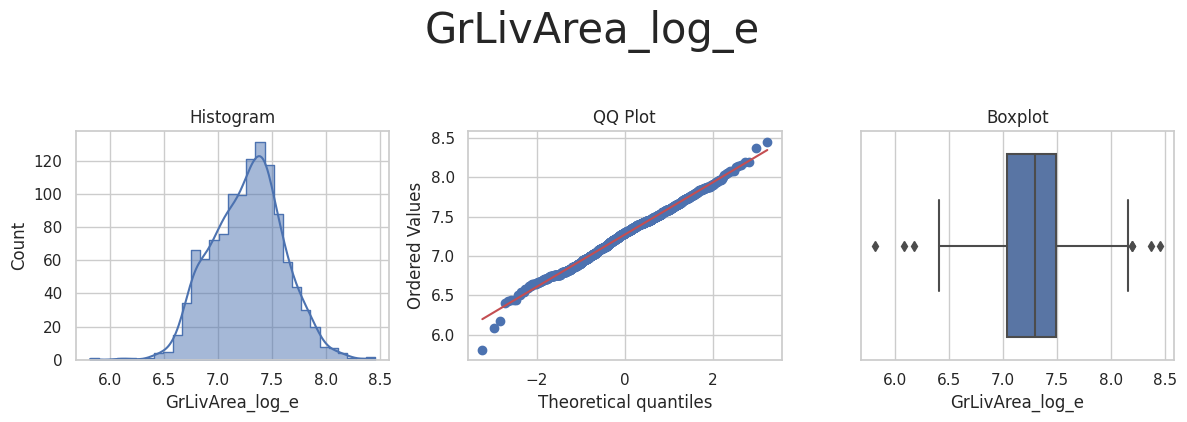

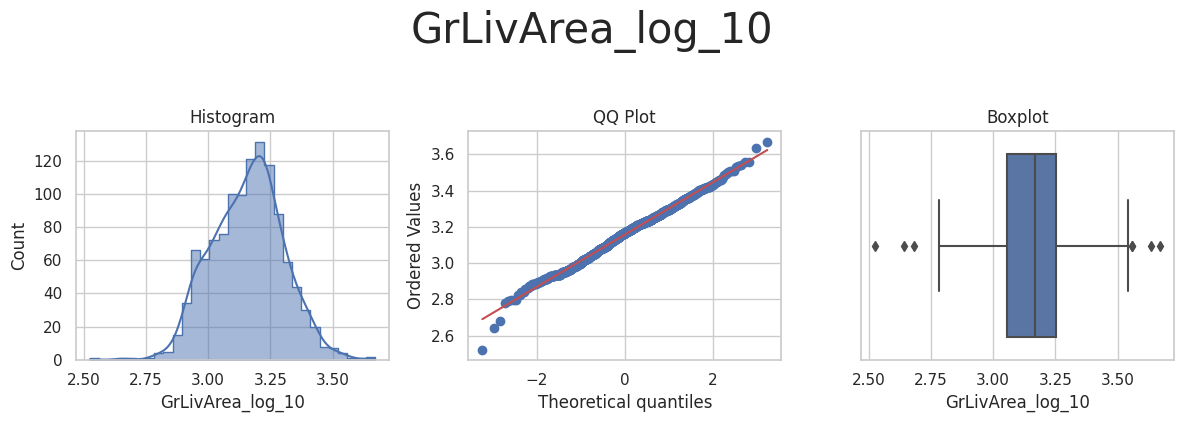

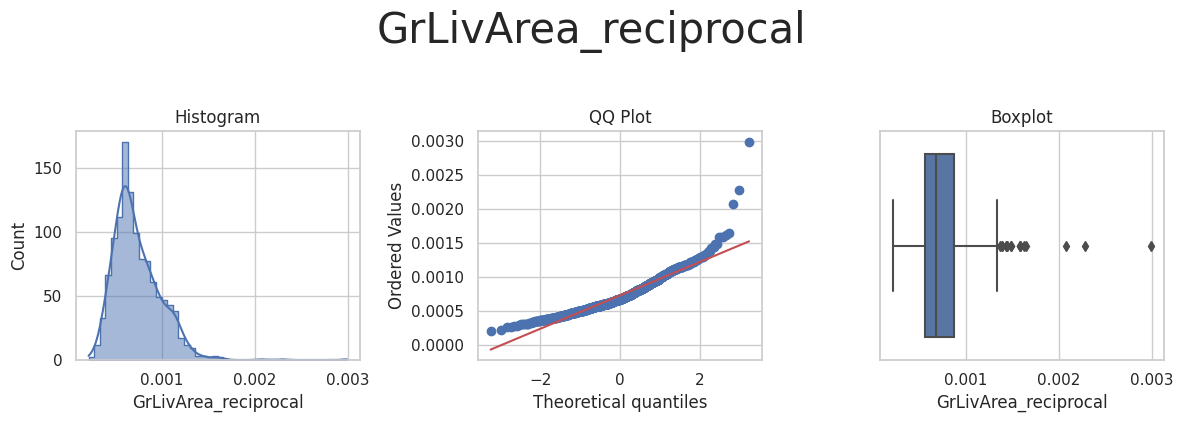

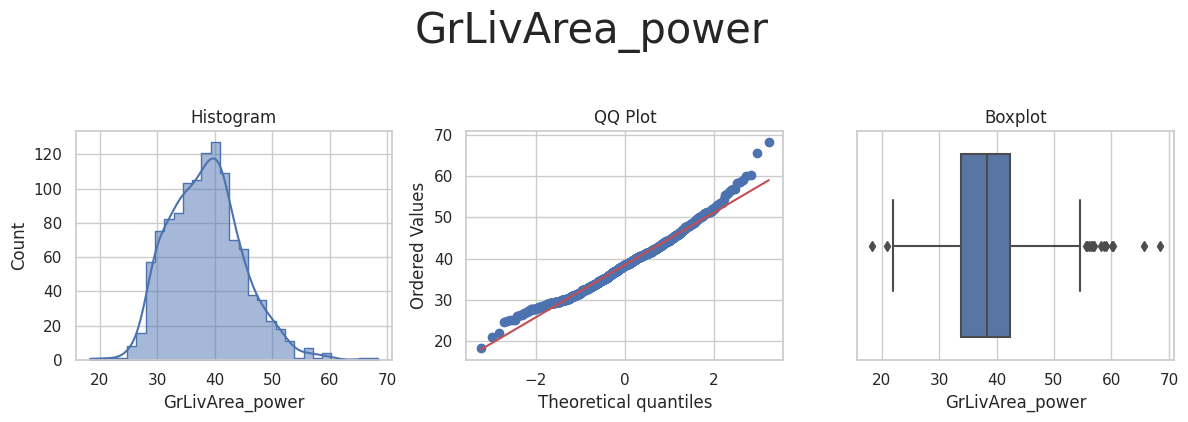

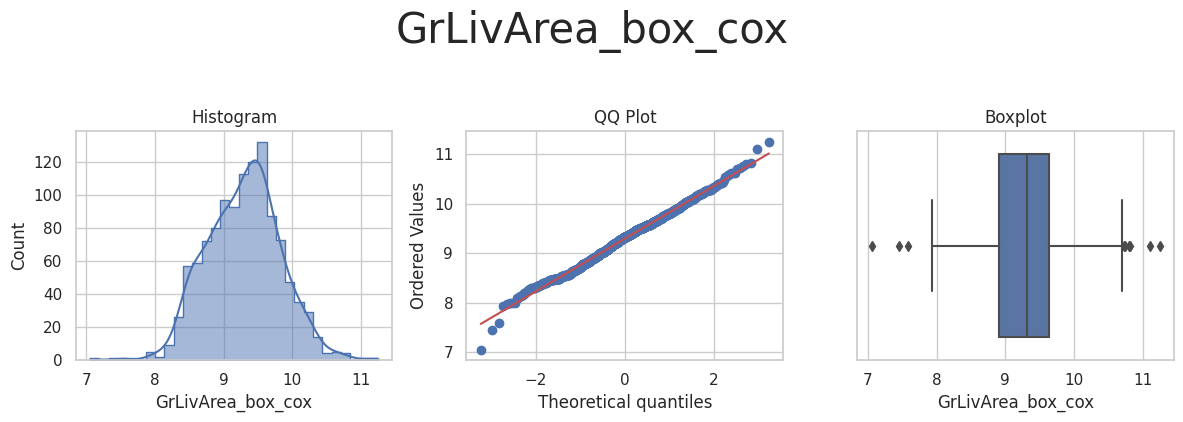

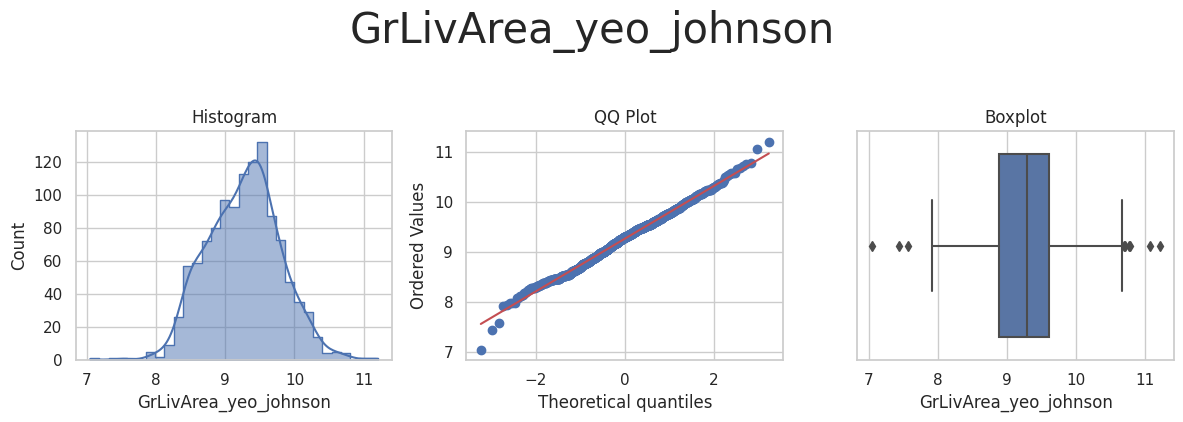



* Variable Analysed: LotArea
* Transformation Applied: ['LotArea_log_e', 'LotArea_log_10', 'LotArea_reciprocal', 'LotArea_power', 'LotArea_box_cox', 'LotArea_yeo_johnson'] 



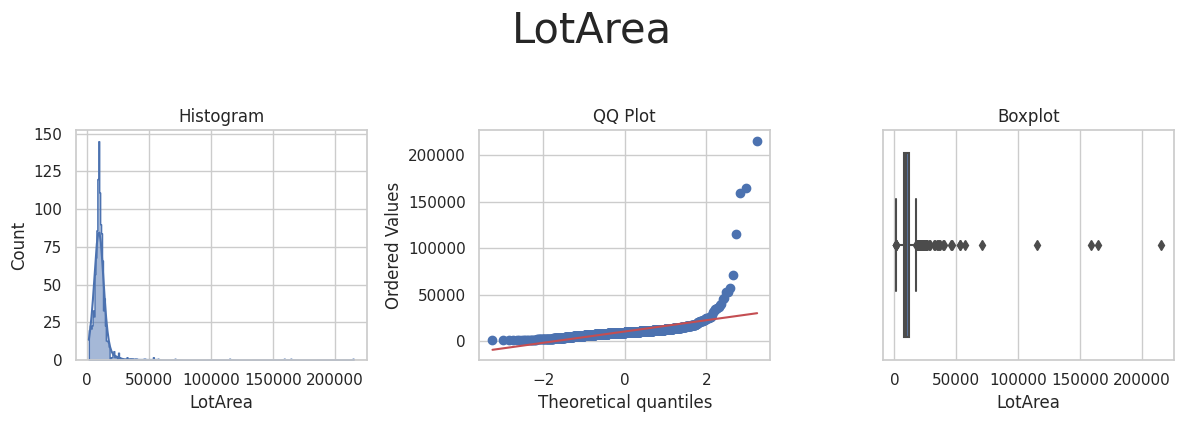

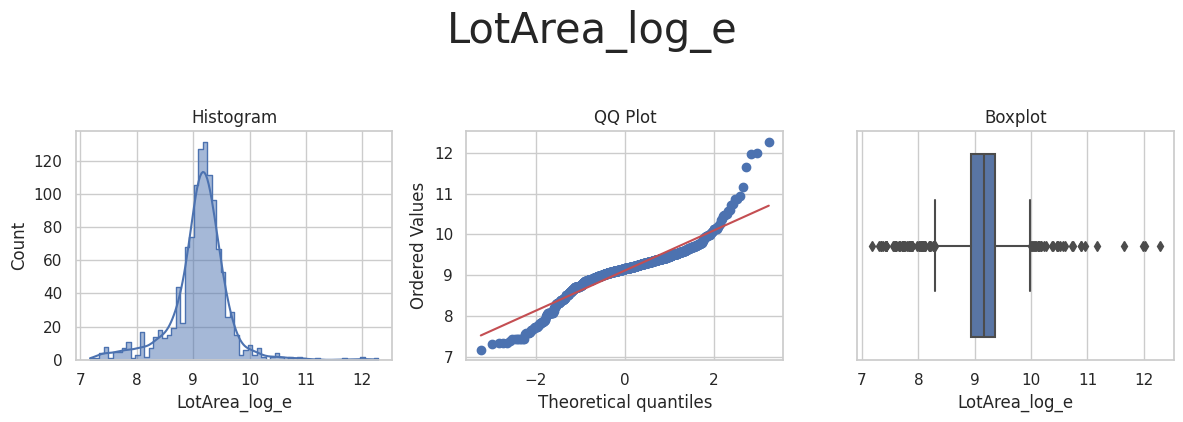

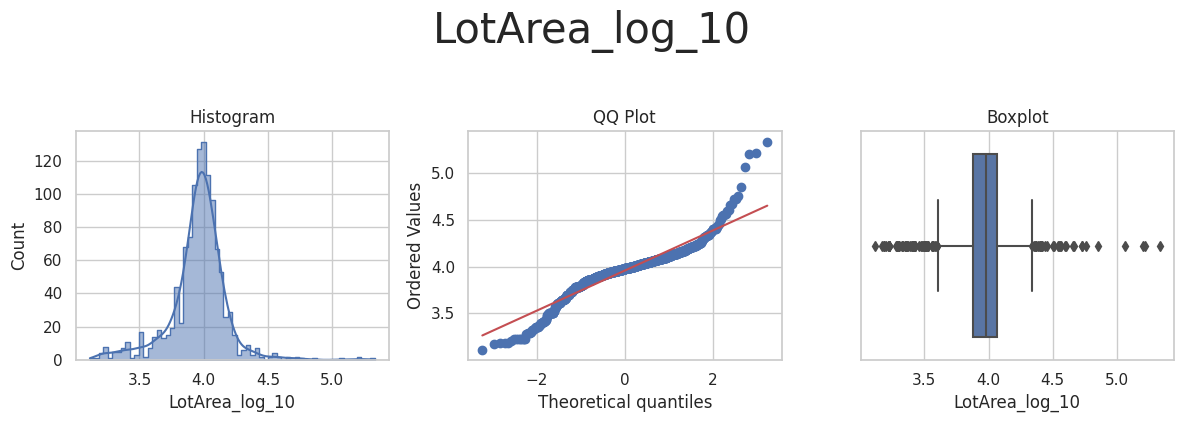

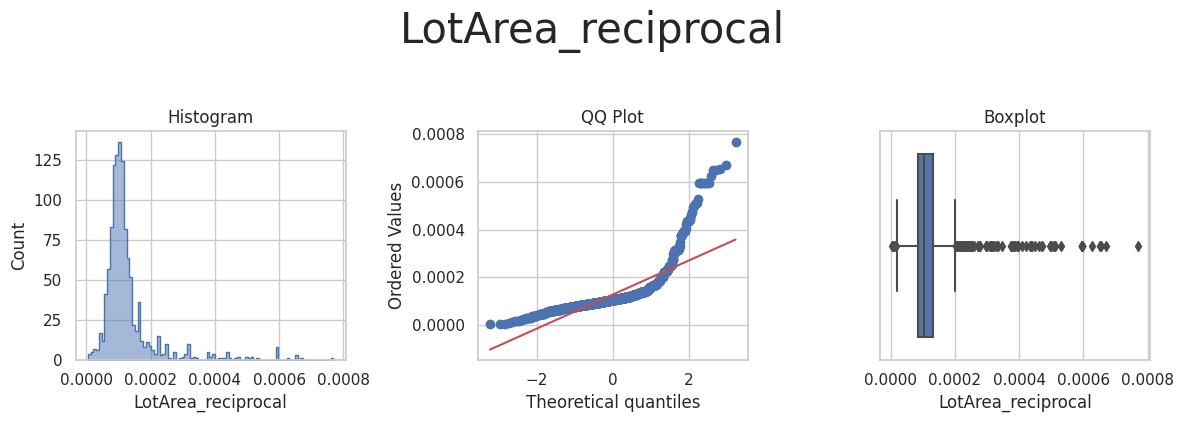

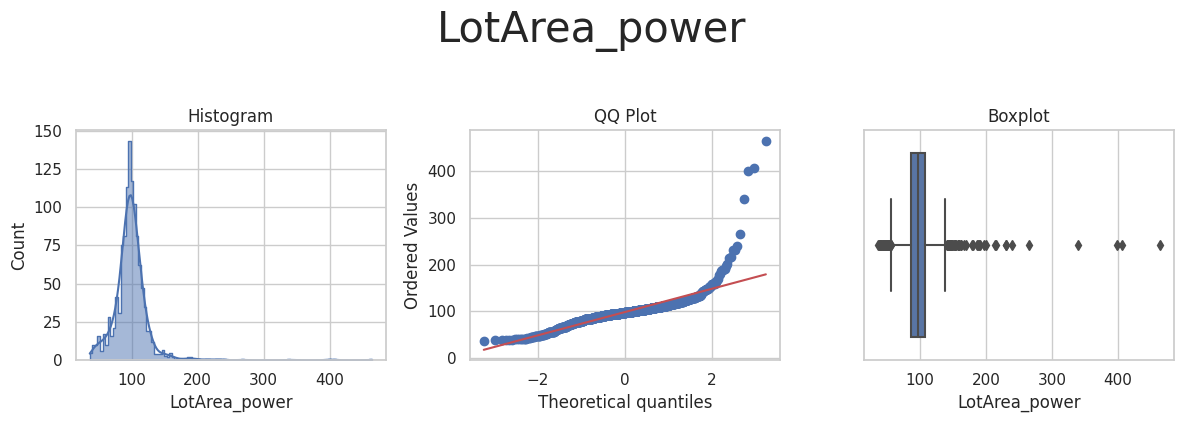

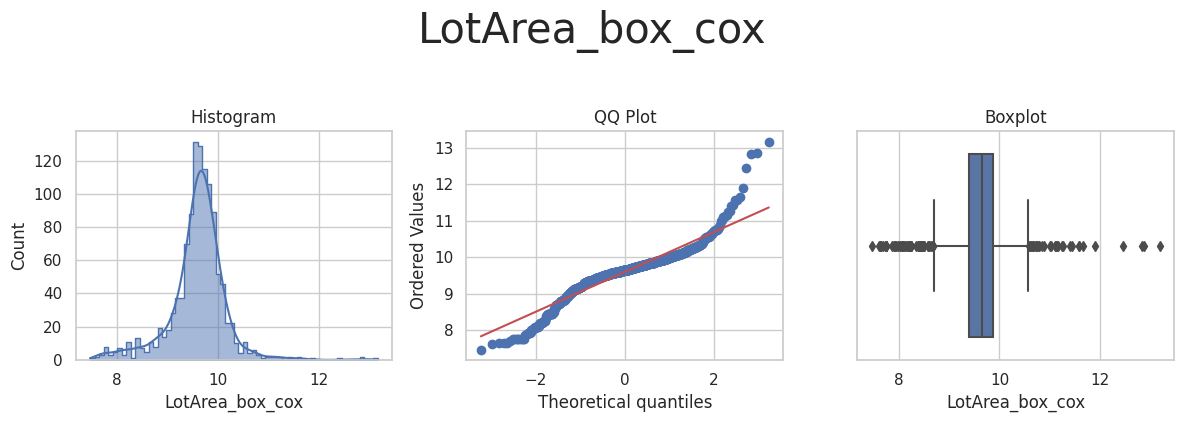

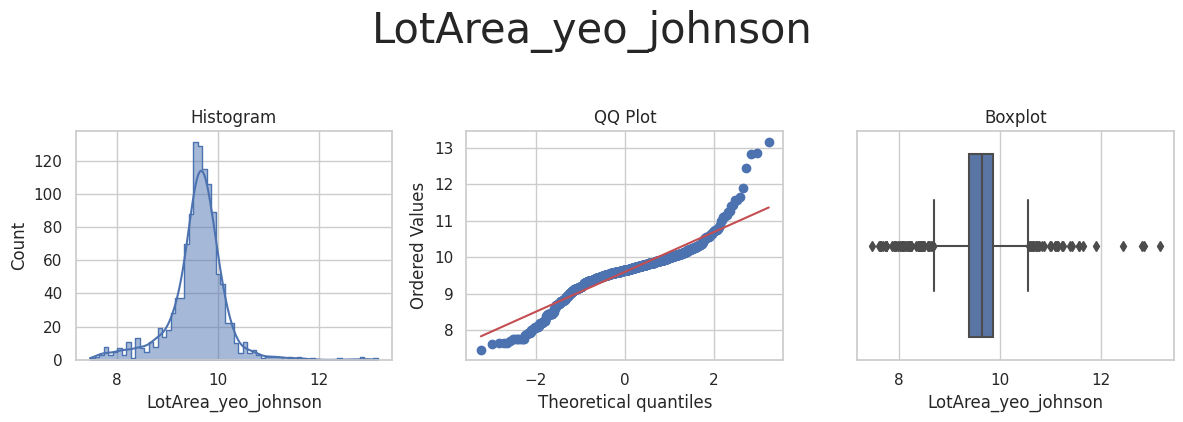



* Variable Analysed: LotFrontage
* Transformation Applied: ['LotFrontage_log_e', 'LotFrontage_log_10', 'LotFrontage_reciprocal', 'LotFrontage_power', 'LotFrontage_box_cox', 'LotFrontage_yeo_johnson'] 



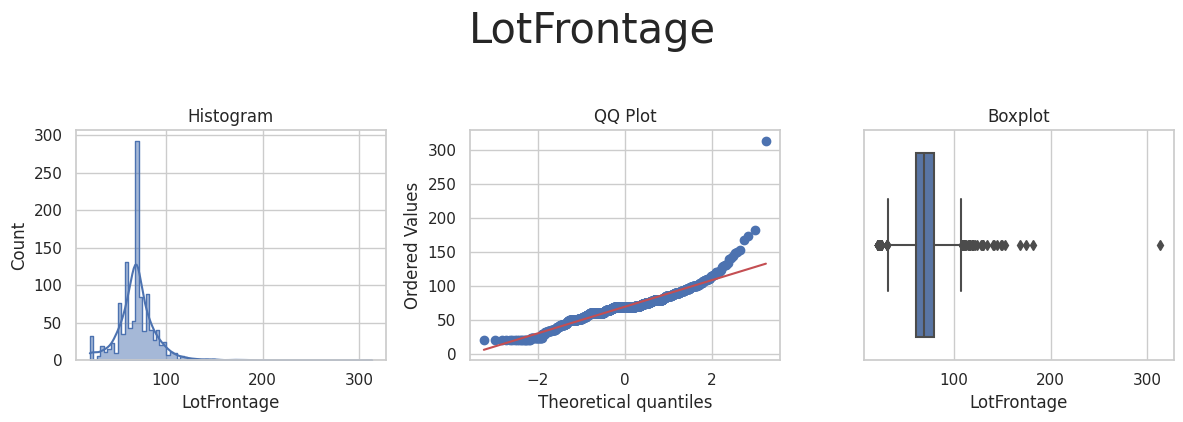

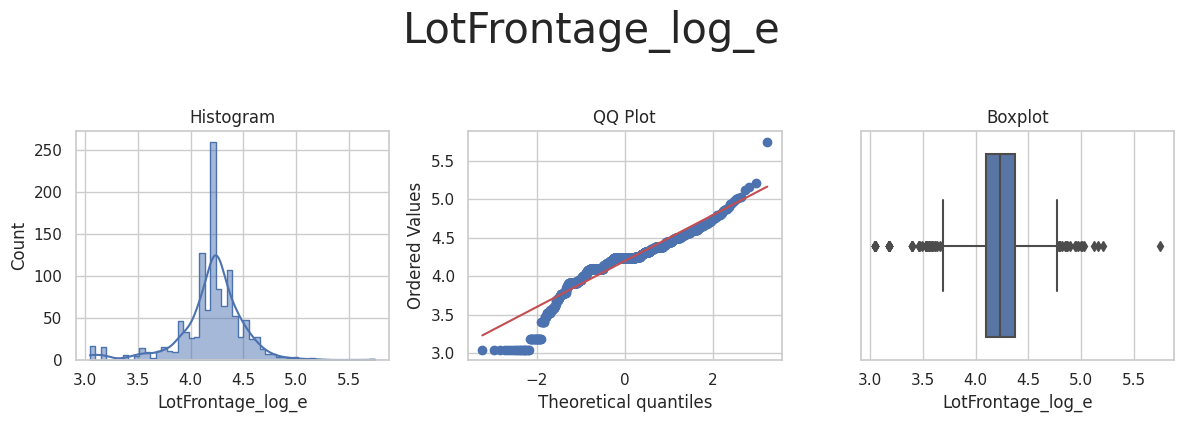

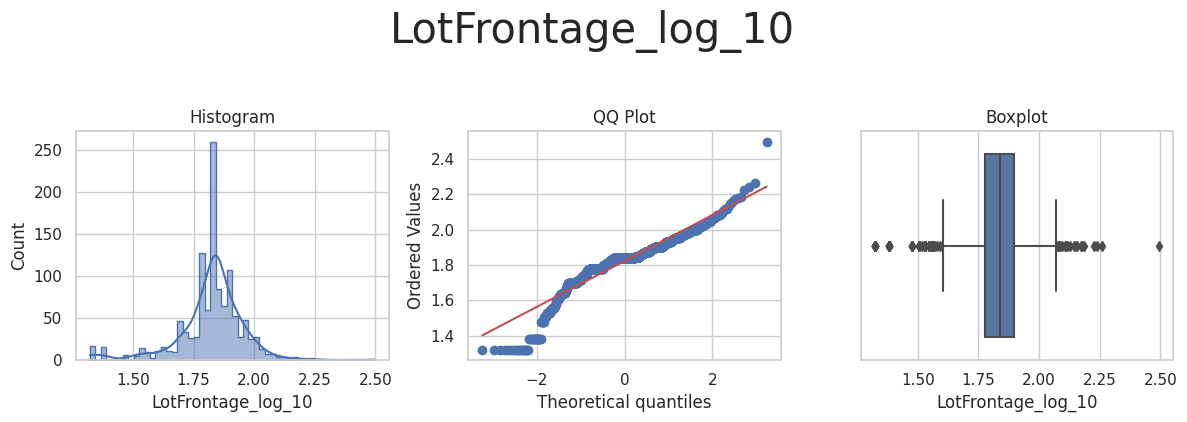

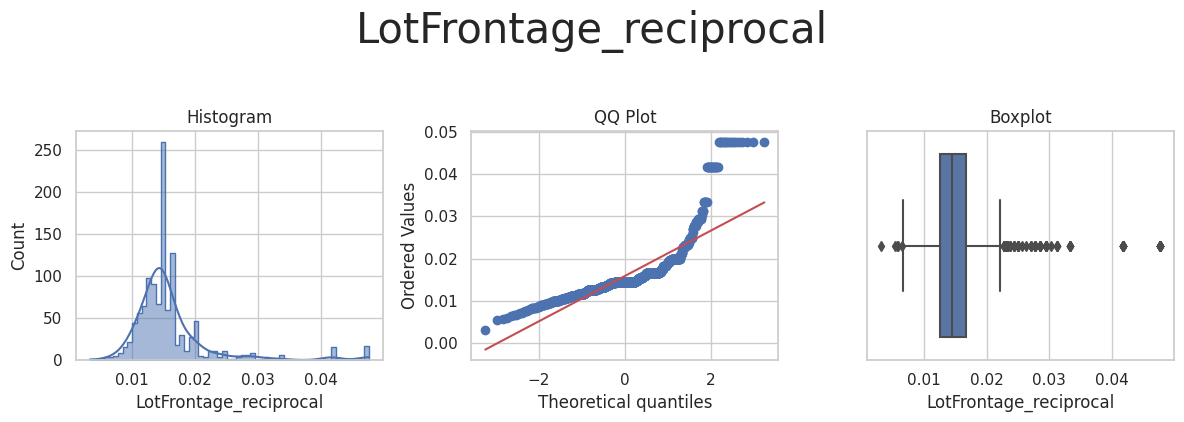

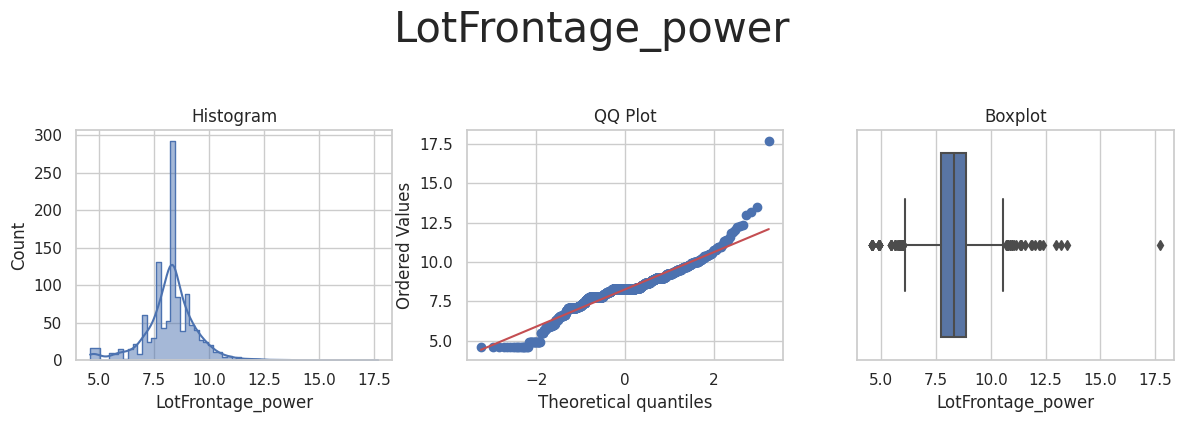

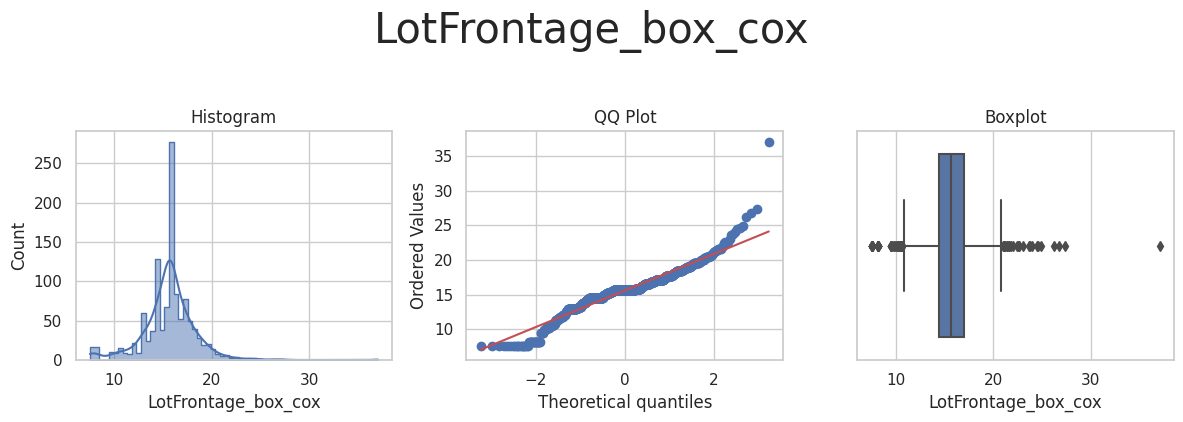

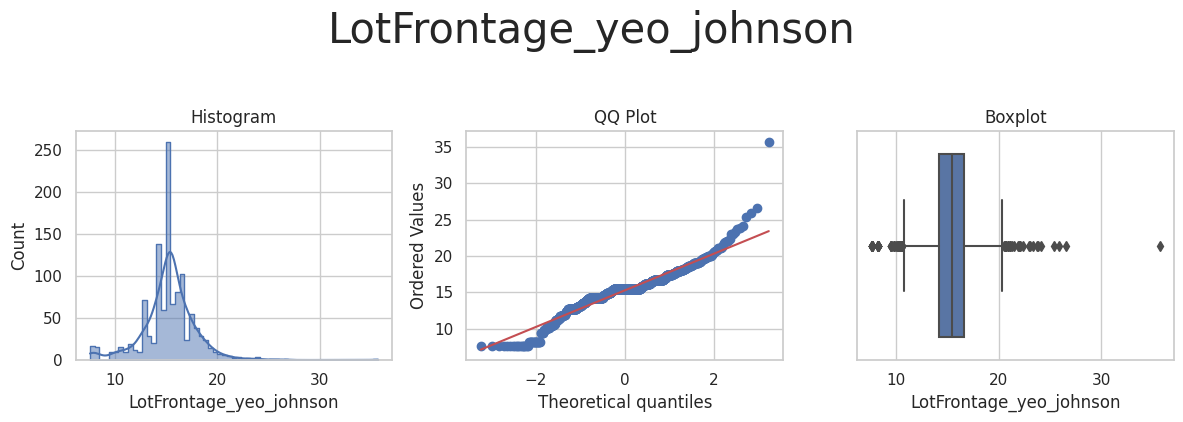



* Variable Analysed: MasVnrArea
* Transformation Applied: ['MasVnrArea_power', 'MasVnrArea_yeo_johnson'] 



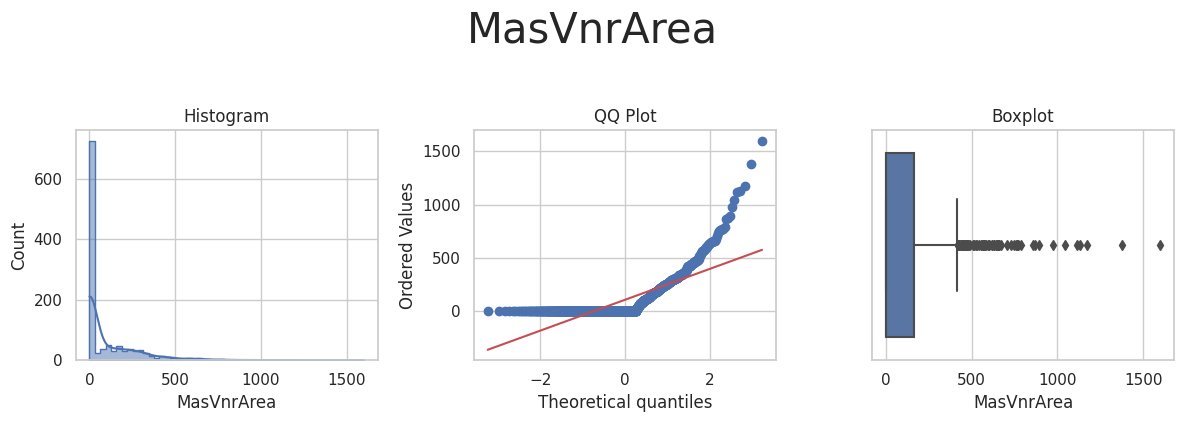

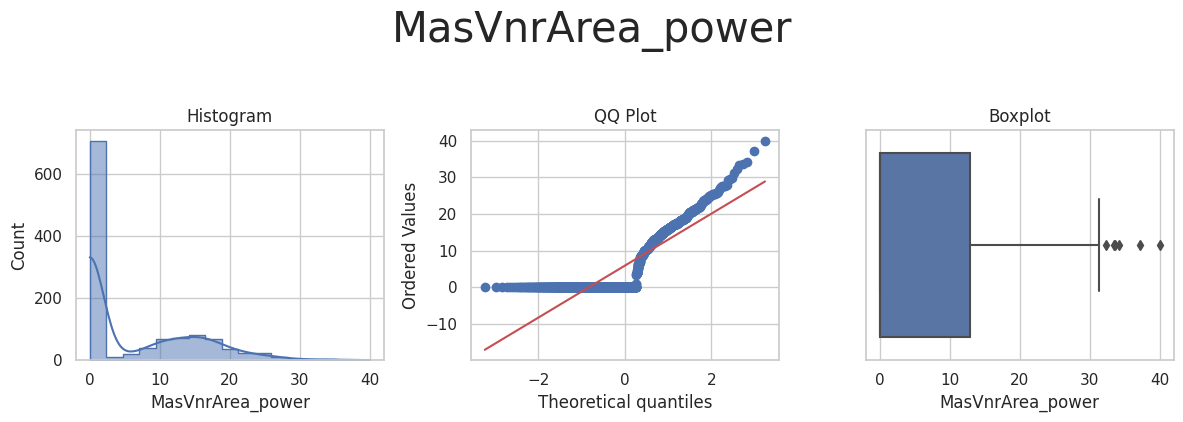

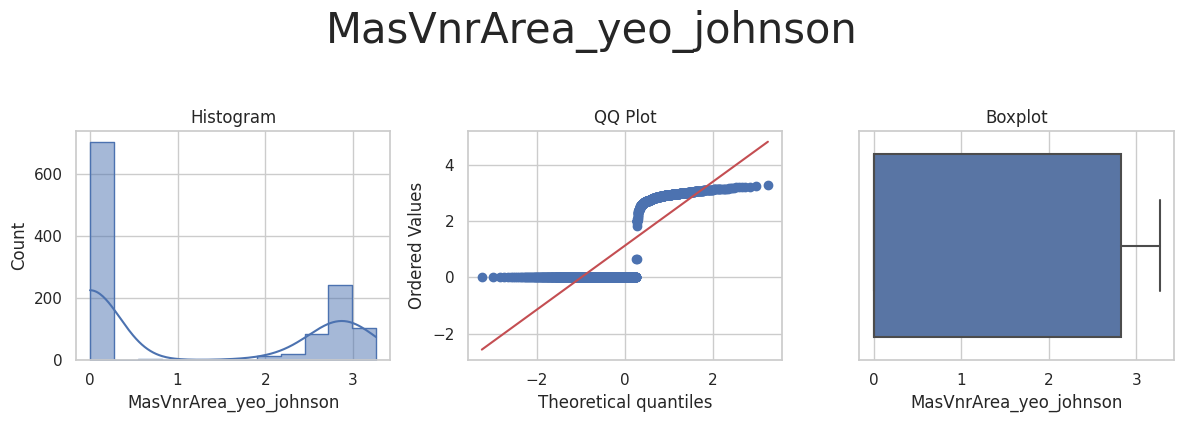



* Variable Analysed: OpenPorchSF
* Transformation Applied: ['OpenPorchSF_power', 'OpenPorchSF_yeo_johnson'] 



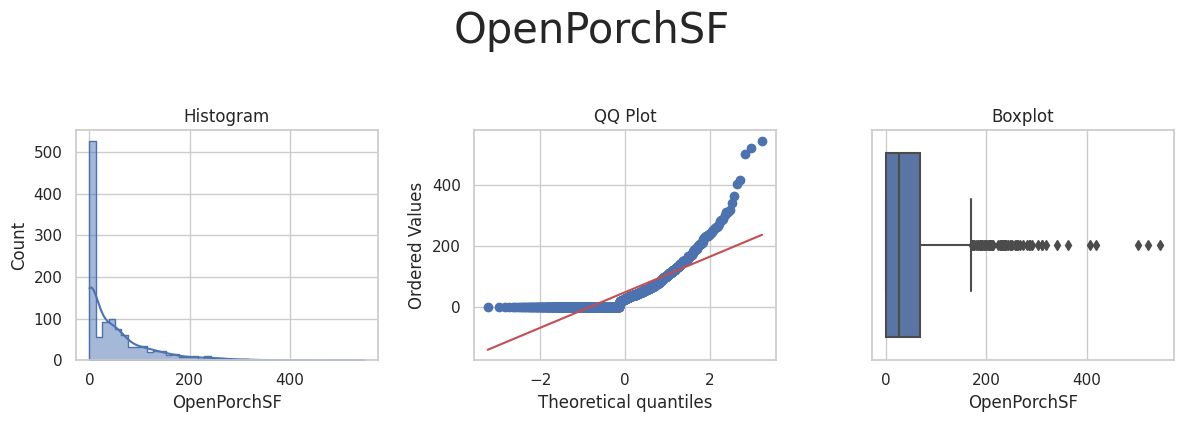

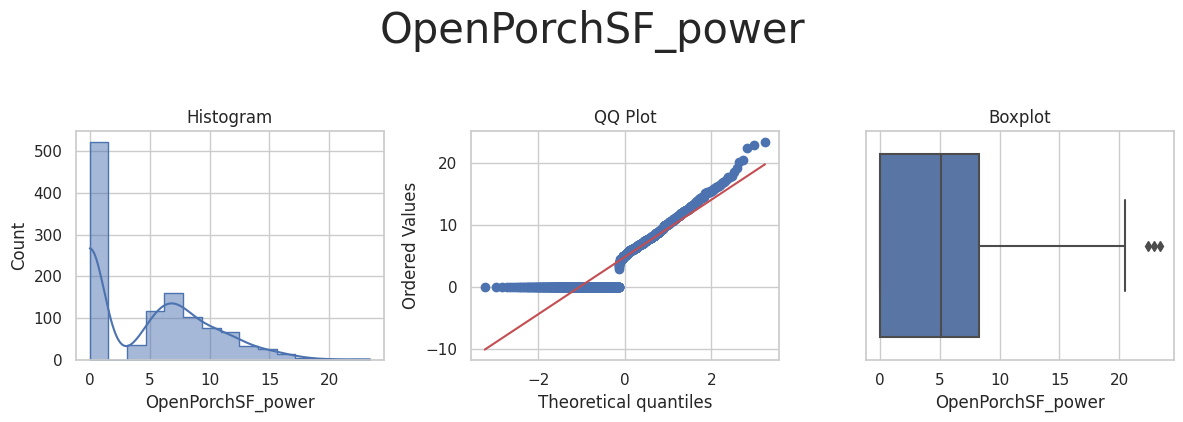

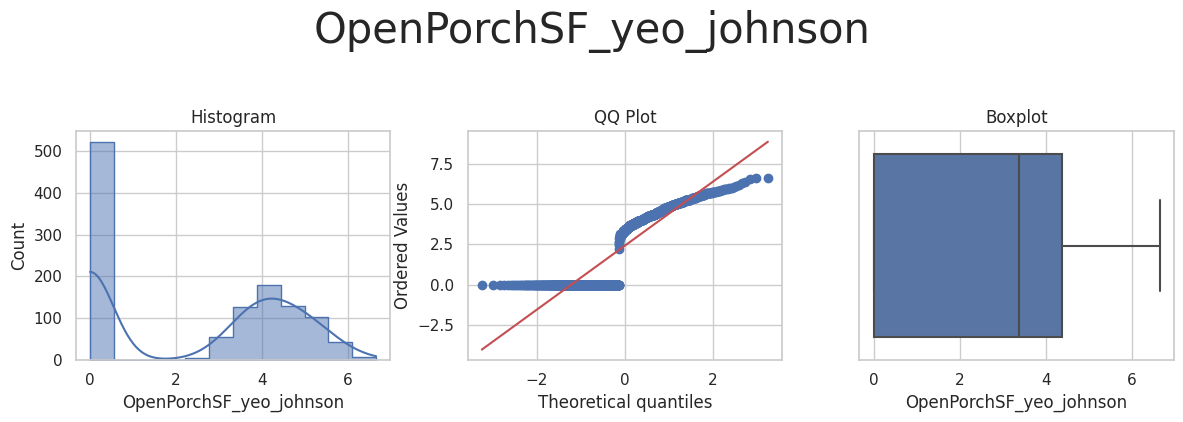

In [18]:
df_engineering = FeatureEngineeringAnalysis(df=df_engineering, analysis_type='numerical')

### Conclusion

* 1stFlrSF: Transformations Applied: log_e, log_10, reciprocal, power, box_cox, yeo_johnson. Proposed transformation: log_e
* 2ndFlrSF: Transformations Applied: power, yeo_johnson. Proposed transformation: none
* BsmtFinSF1: Transformations Applied: power, yeo_johnson. Proposed transformation: none
* BsmtUnfSF: Transformations Applied: power, yeo_johnson. Proposed transformation: yeo_johnson
* TotalBsmtSF: Transformations Applied: power, yeo_johnson. Proposed transformation: yeo_johnson
* GarageArea: Transformation Applied: power, yeo_johnson. Proposed transformations: yeo_johnson
* GrLivArea: Transformation Applied: log_e, log_10, reciprocal, power, box_cox, yeo_johnson. Proposed transformations: log_e
* LotArea: Transformations Applied: log_e, log_10, reciprocal, power, box_cox, yeo_johnson. Proposed transformations: power
* LotFrontage: Transformations Applied: log_e, log_10, reciprocal, prower, box_cox, yeo_johnson. Proposed transformation: none
* MasVnrArea: Transformations Applied: power, yeo_johnson. Proposed transformations: none
* OpenPorchSF: Transformations Applied: power, yeo_johnson. Proposed transformations: none

Step 4: Apply the selected transformation to the Train and Test setCreate engineered variable(s) applying the transformation(s), assess engineered variables distribution and select most suitable method

In [22]:
from sklearn.pipeline import Pipeline

variables_engineering_log = ['1stFlrSF', 'GrLivArea']
variables_engineering_yeo_johnson = ['BsmtUnfSF', 'TotalBsmtSF', 'GarageArea']
variables_engineering_power = ['LotArea']

pipeline = Pipeline ([
    ("NumericLogTransform", vt.LogTransformer(variables=variables_engineering_log, base='e')),
    ("NumericYeoJohnsonTransform", vt.YeoJohnsonTransformer(variables=variables_engineering_yeo_johnson)),
    ("NumericPowerTransform", vt.PowerTransformer(variables=variables_engineering_power))
])
TrainSet = pipeline.fit_transform(TrainSet)
TestSet = pipeline.transform(TestSet)

print("* Numerical Transformations Done!")

* Numerical Transformations Done!


## Outlier Winsorizer

Step 1: Select variables
Step 2: Create separate DataFrame

In [20]:
df_engineering = TrainSet.copy()
df_engineering.head(3)

1stFlrSF  2ndFlrSF  BedroomAbvGr  BsmtExposure  BsmtFinSF1  BsmtFinType1  \
0  7.510978       0.0           3.0             0          48             0   
1  6.795706       0.0           2.0             1           0             0   
2  6.871091       0.0           2.0             1         713             1   

   BsmtUnfSF  GarageArea  GarageFinish  GarageYrBlt  ...     LotArea  \
0  72.117860  285.045723             0       2007.0  ...  108.138800   
1  51.451694  133.391173             0       1962.0  ...   81.240384   
2  21.751877  176.329005             0       1921.0  ...  115.585466   

   LotFrontage  MasVnrArea  OpenPorchSF  OverallCond  OverallQual  \
0         90.0       452.0          108            5            9   
1         60.0         0.0            0            5            5   
2         80.0         0.0            0            7            5   

   TotalBsmtSF  YearBuilt  YearRemodAdd  SalePrice  
0   495.850351       2007          2007     314813  
1   280.785318       1962          1962     109500  
2   276.257124       1921          2006     163500  

[3 rows x 22 columns]

Step 3: Create engineered variable applying the transformations, assess the variables distribution and select suitable method

* Variable Analysed: 1stFlrSF
* Transformation Applied: ['1stFlrSF_iqr'] 



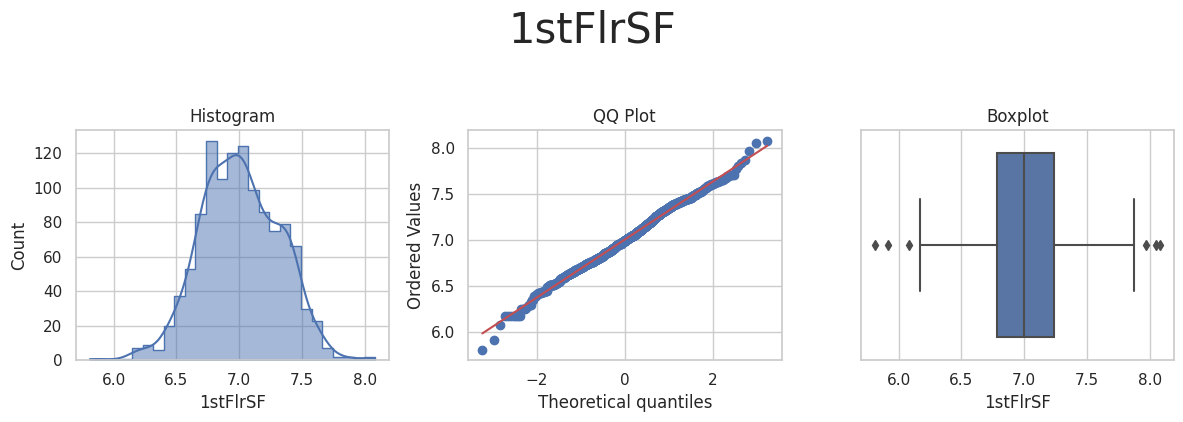

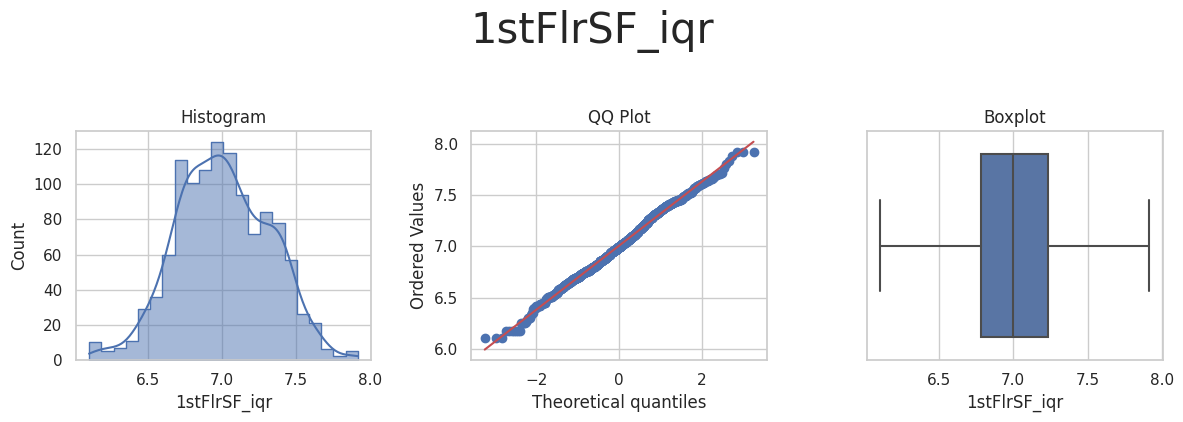



* Variable Analysed: 2ndFlrSF
* Transformation Applied: ['2ndFlrSF_iqr'] 



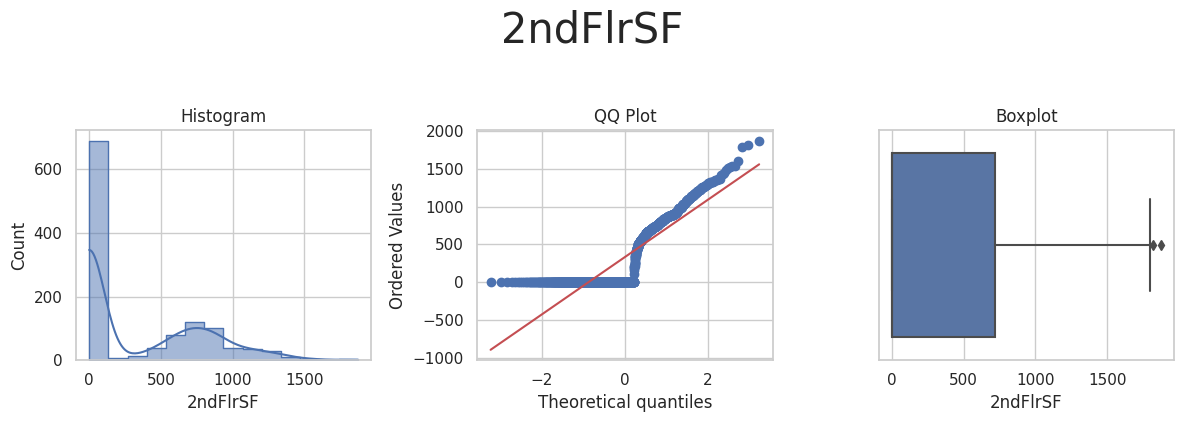

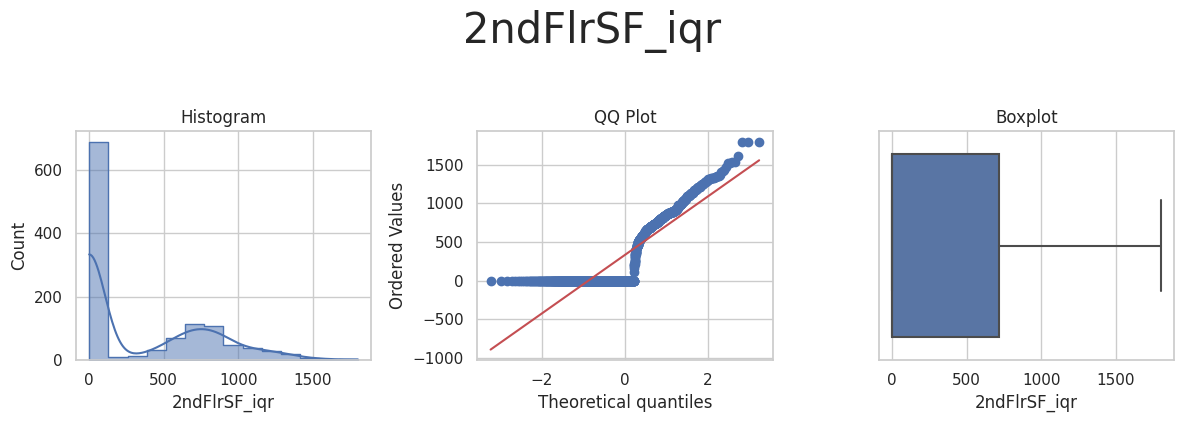



* Variable Analysed: BedroomAbvGr
* Transformation Applied: ['BedroomAbvGr_iqr'] 



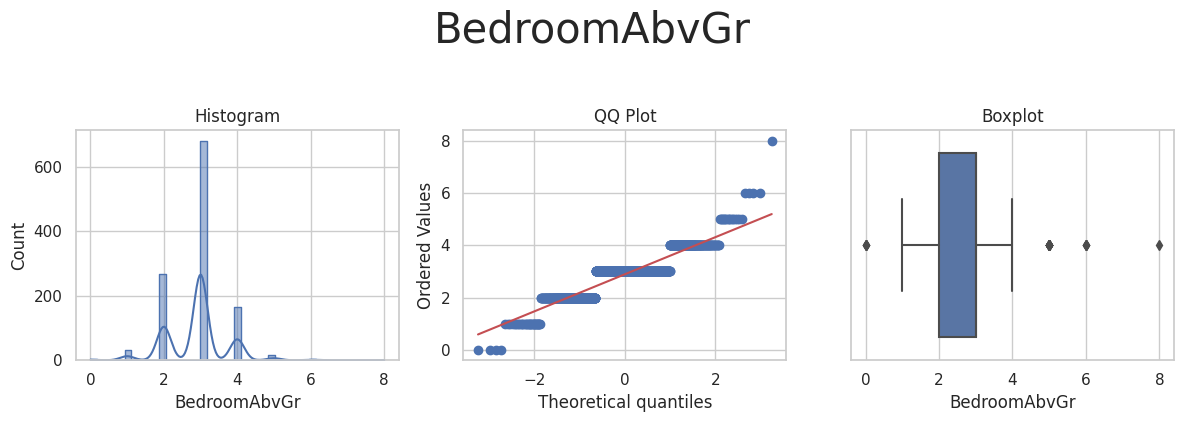

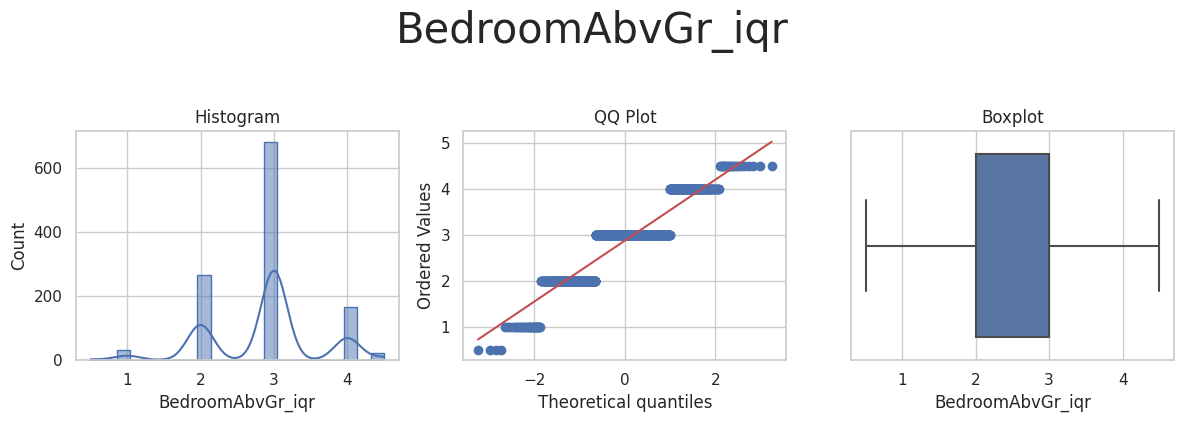



* Variable Analysed: BsmtExposure
* Transformation Applied: ['BsmtExposure_iqr'] 



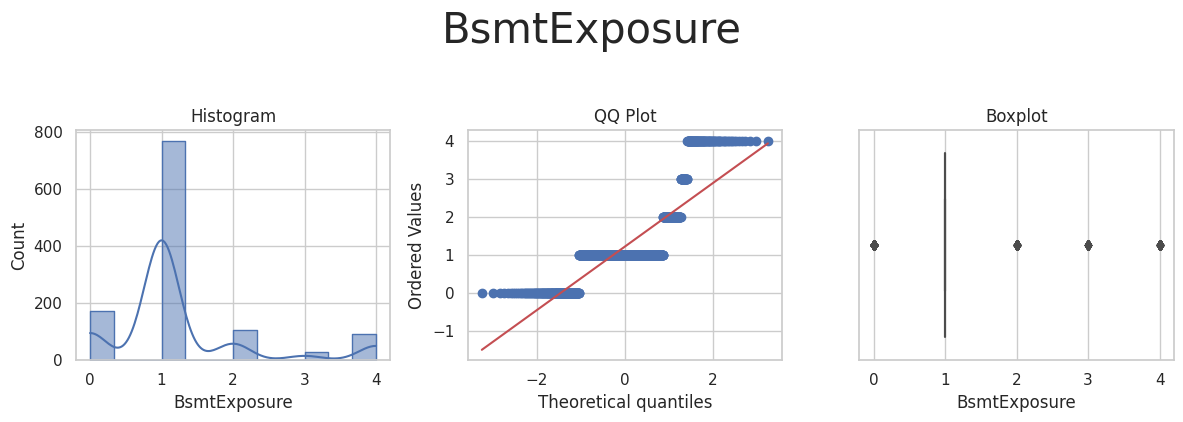

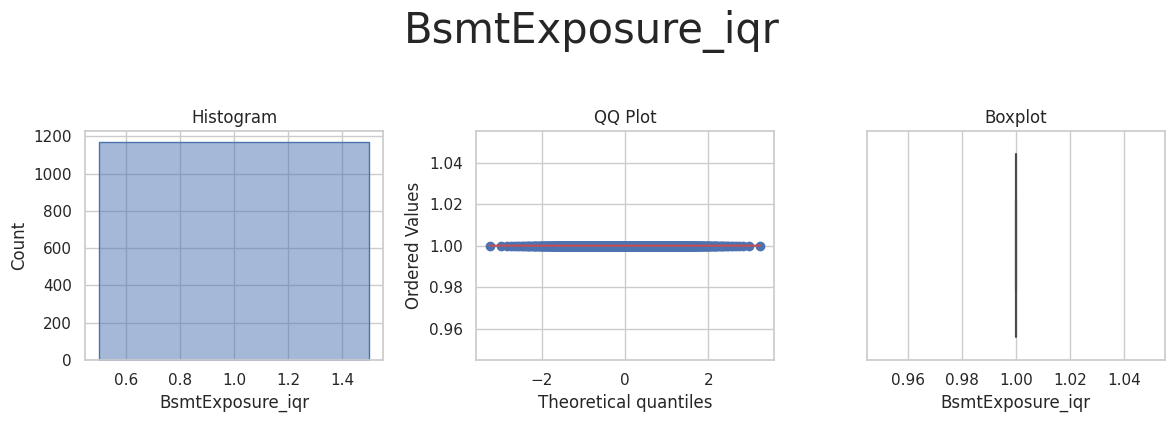



* Variable Analysed: BsmtFinSF1
* Transformation Applied: ['BsmtFinSF1_iqr'] 



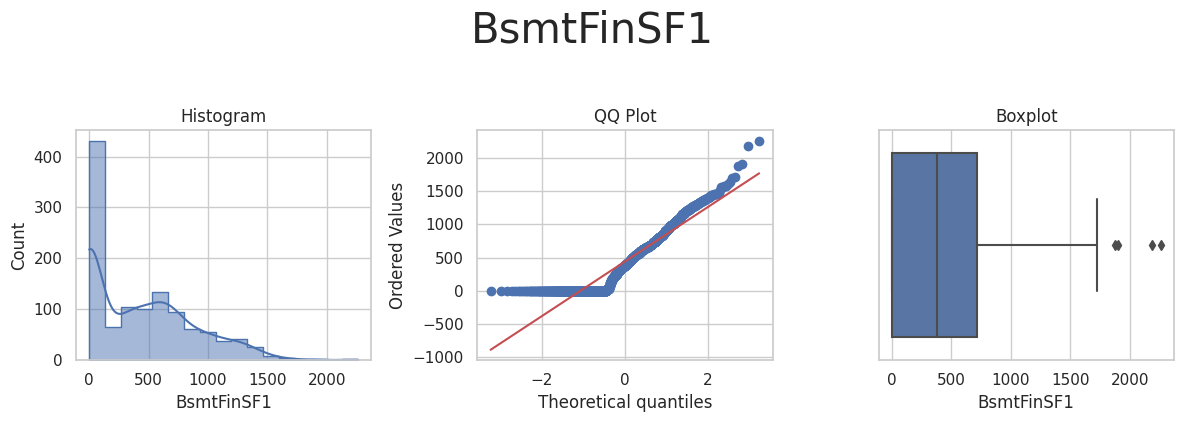

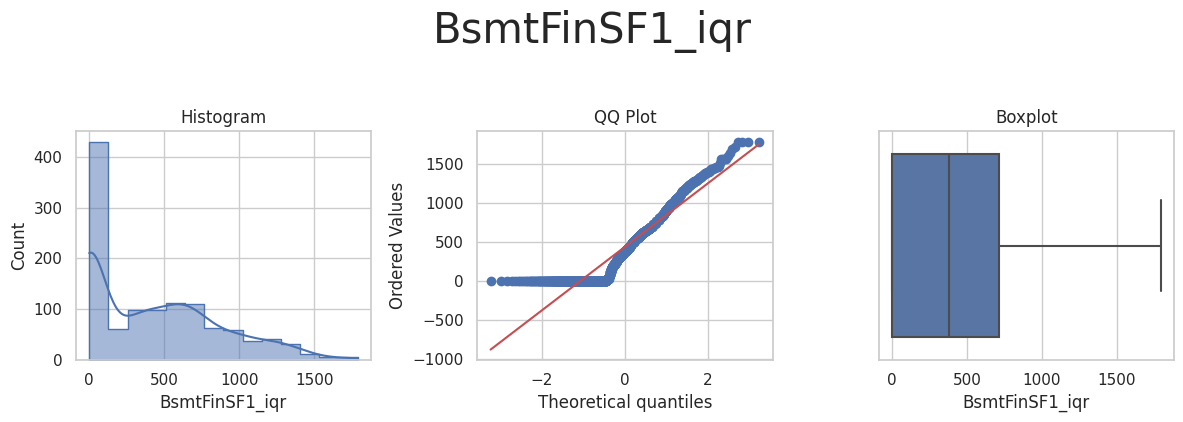



* Variable Analysed: BsmtFinType1
* Transformation Applied: ['BsmtFinType1_iqr'] 



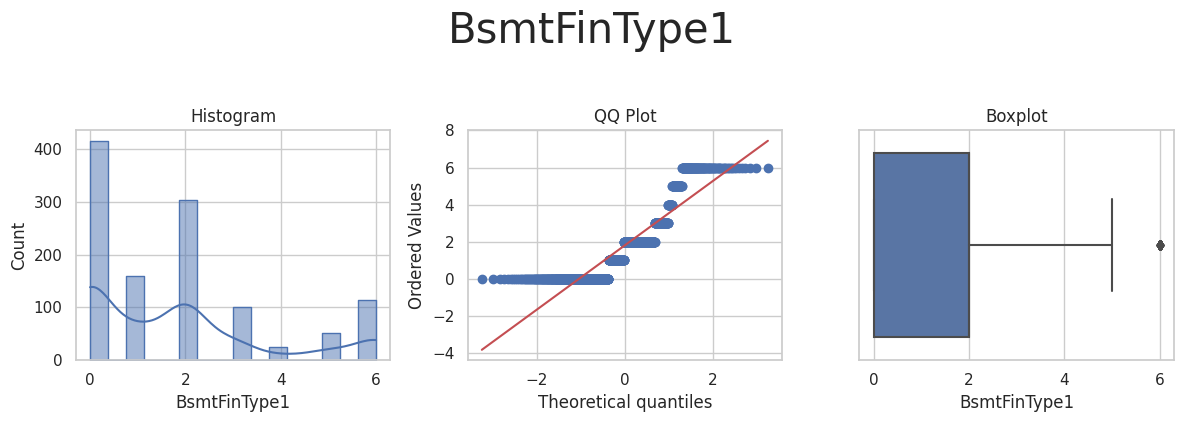

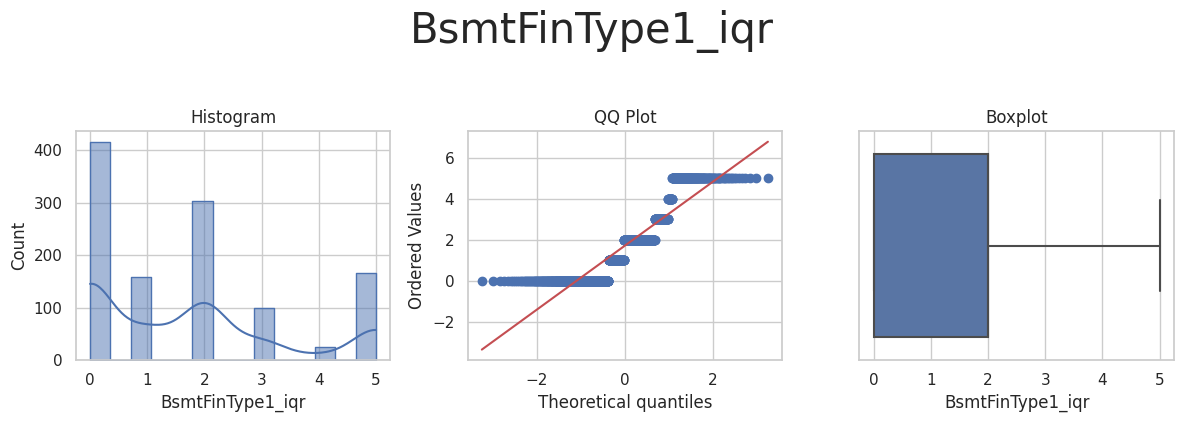



* Variable Analysed: BsmtUnfSF
* Transformation Applied: ['BsmtUnfSF_iqr'] 



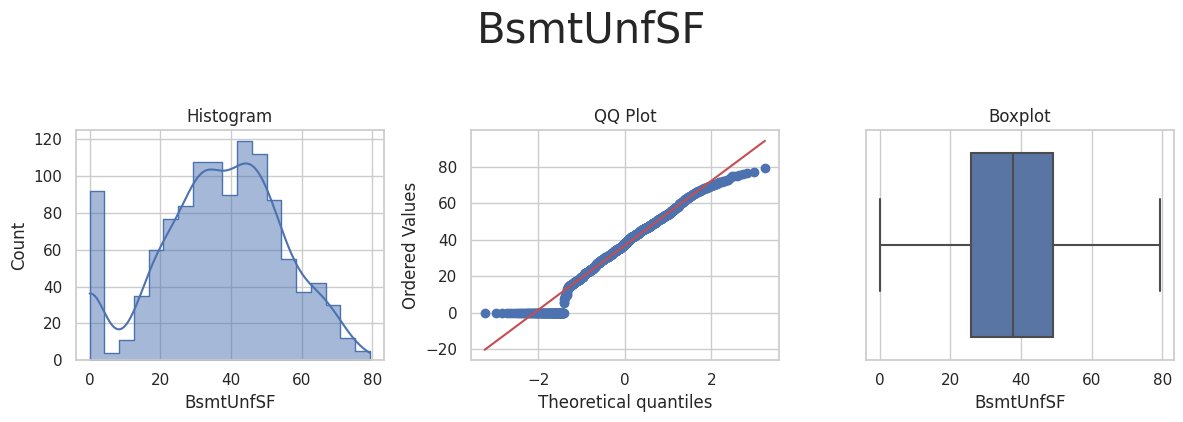

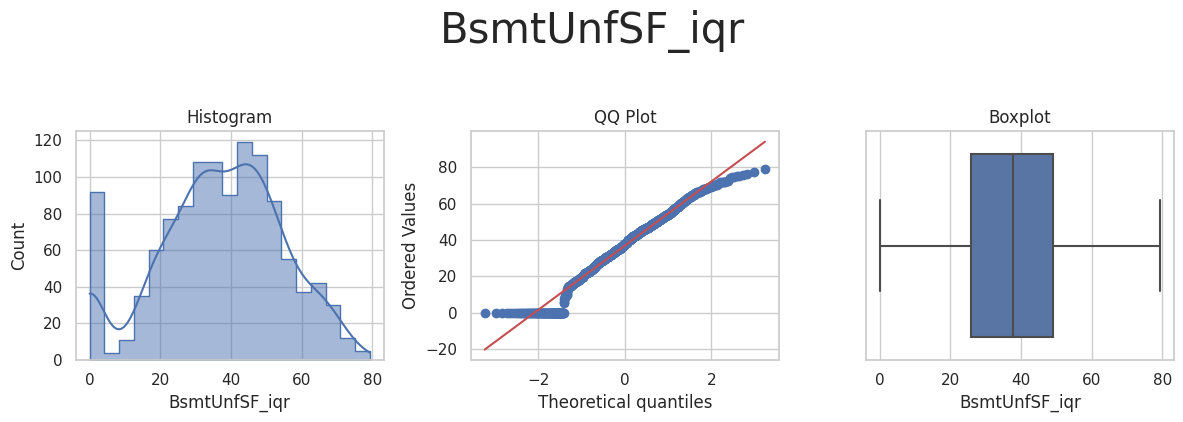



* Variable Analysed: GarageArea
* Transformation Applied: ['GarageArea_iqr'] 



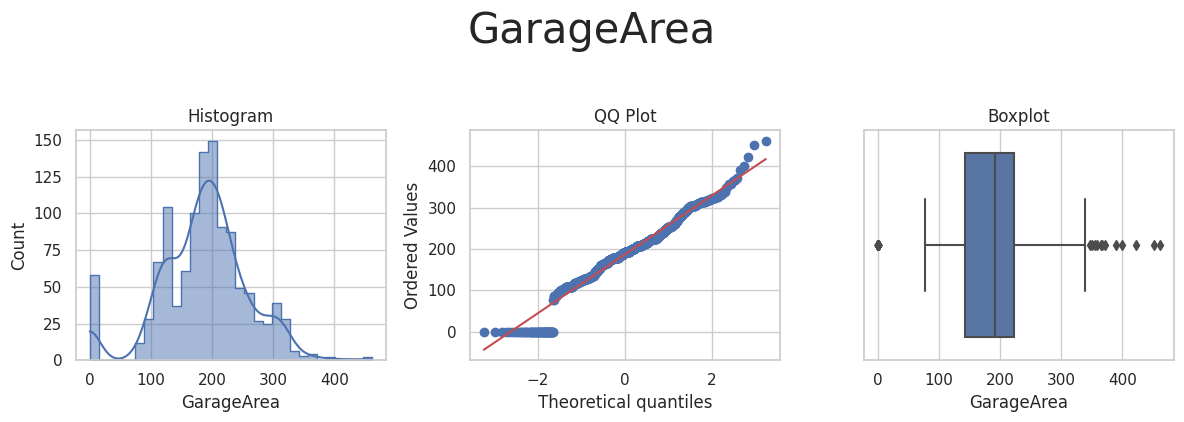

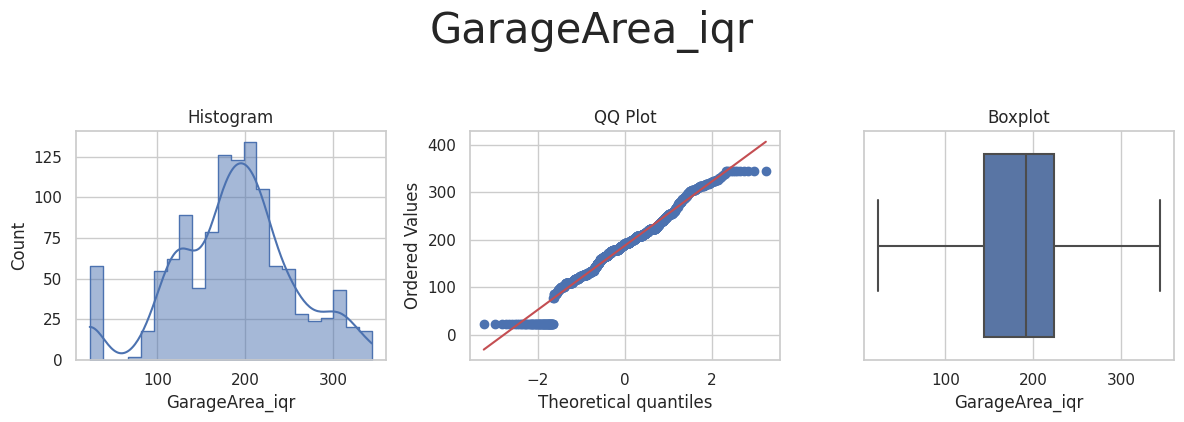



* Variable Analysed: GarageFinish
* Transformation Applied: ['GarageFinish_iqr'] 



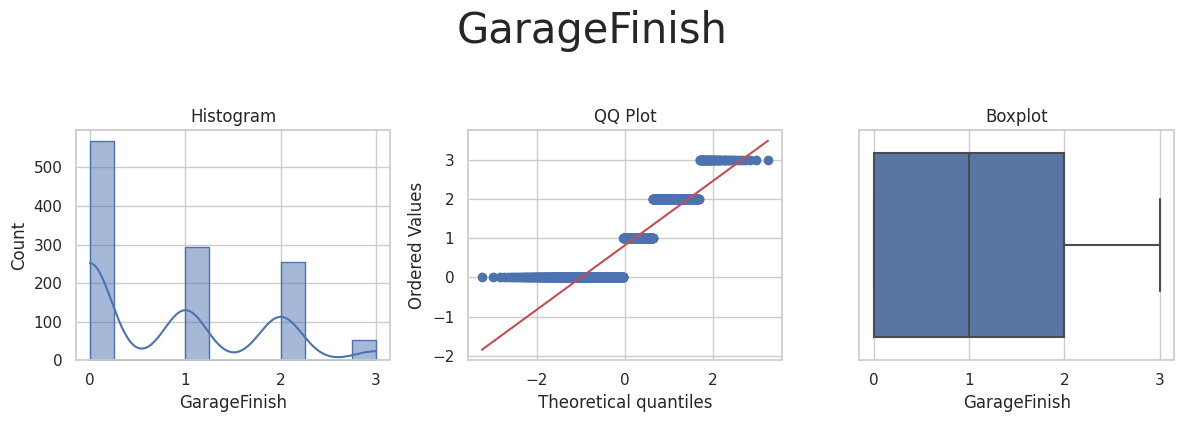

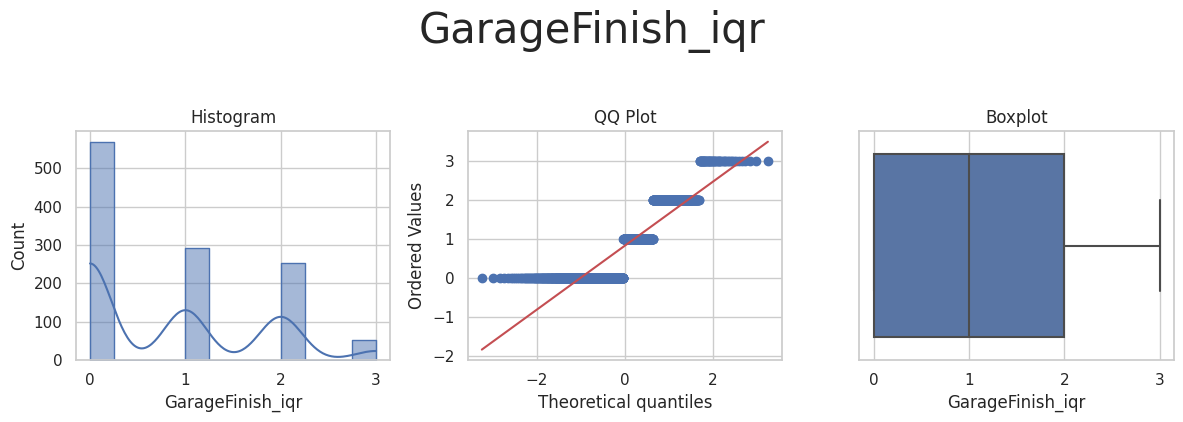



* Variable Analysed: GarageYrBlt
* Transformation Applied: ['GarageYrBlt_iqr'] 



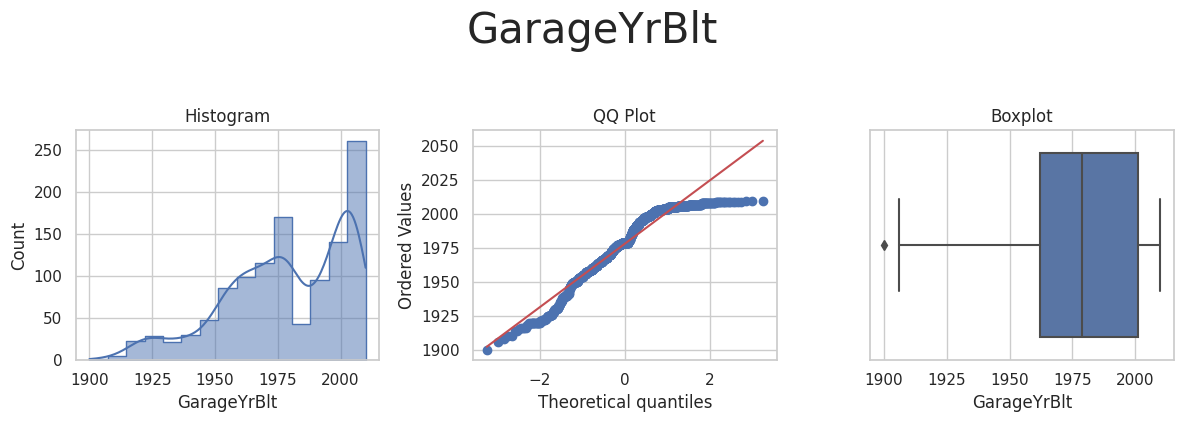

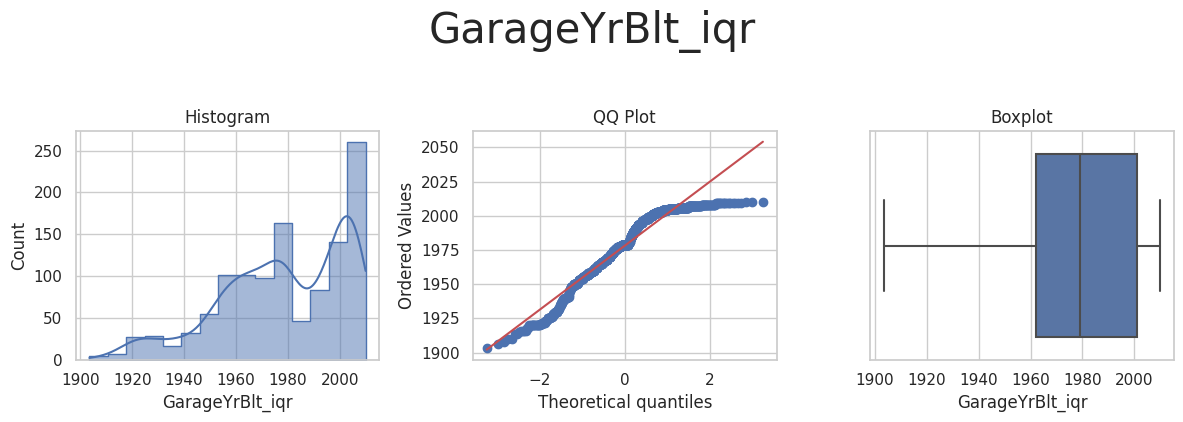



* Variable Analysed: GrLivArea
* Transformation Applied: ['GrLivArea_iqr'] 



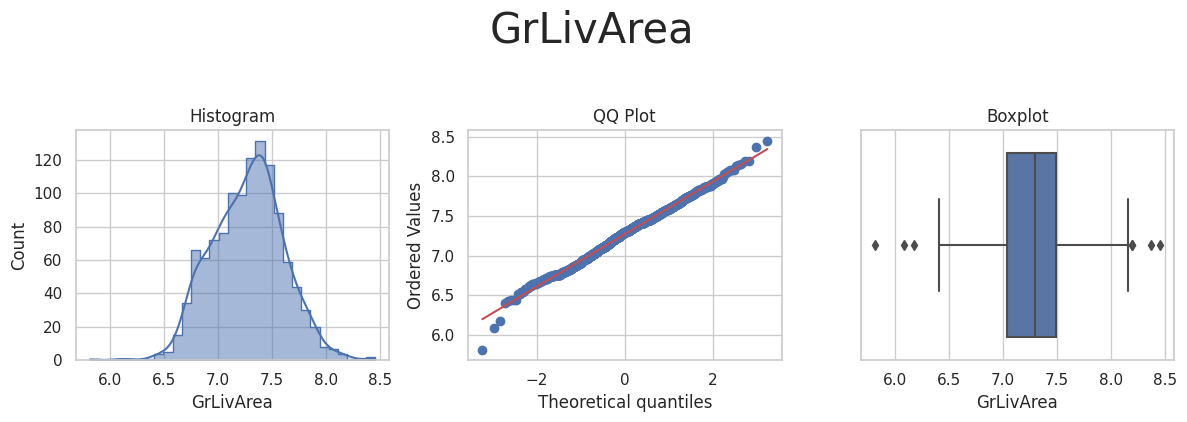

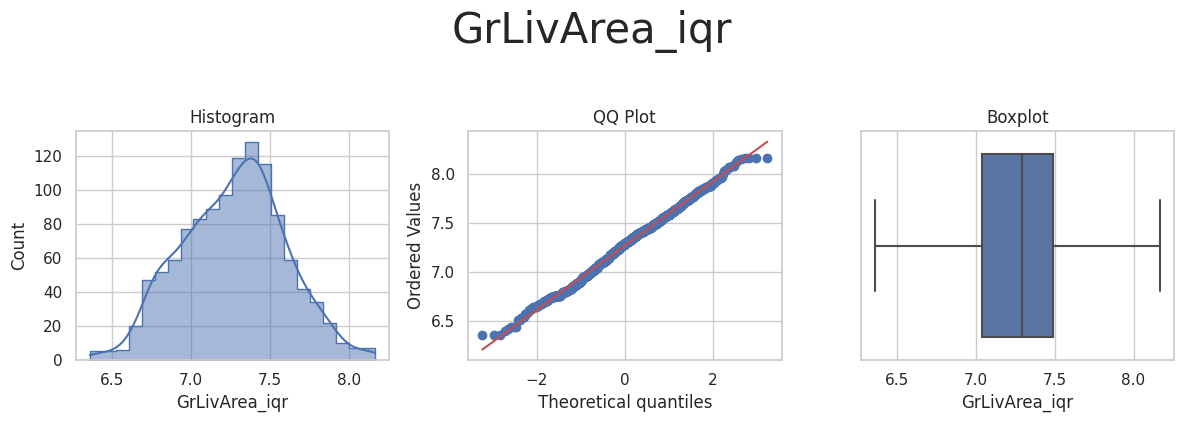



* Variable Analysed: KitchenQual
* Transformation Applied: ['KitchenQual_iqr'] 



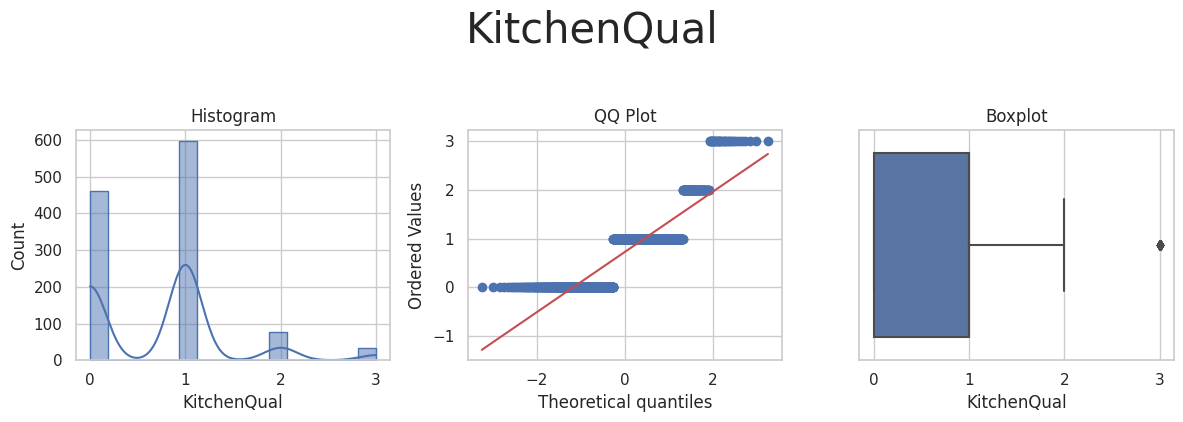

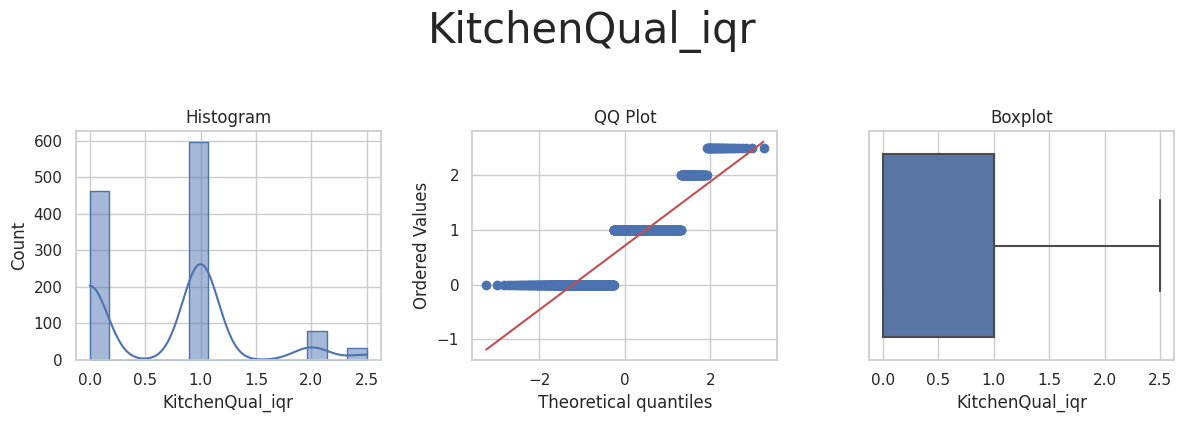



* Variable Analysed: LotArea
* Transformation Applied: ['LotArea_iqr'] 



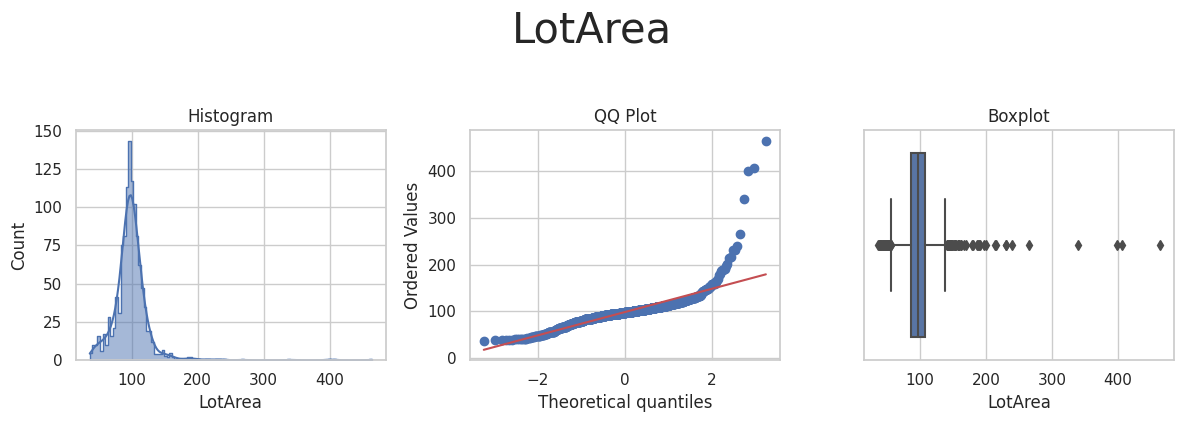

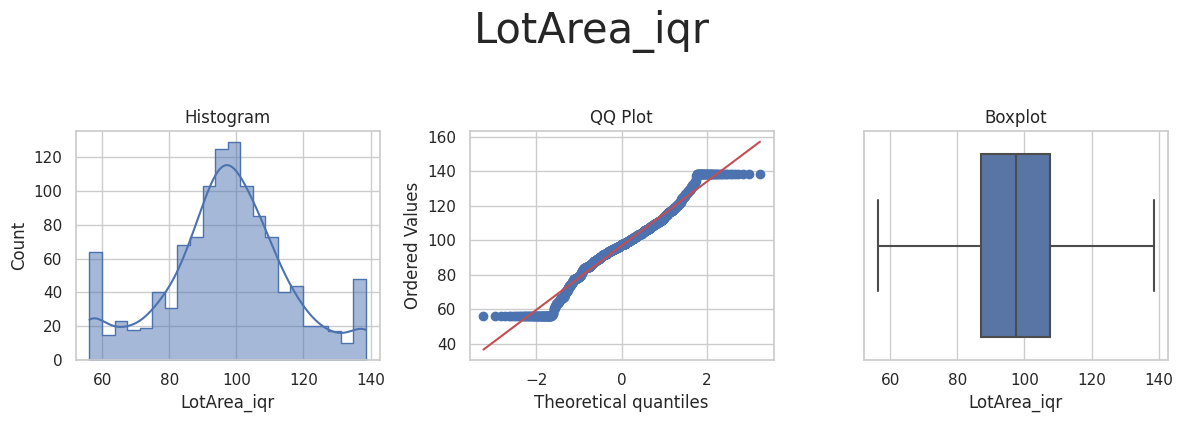



* Variable Analysed: LotFrontage
* Transformation Applied: ['LotFrontage_iqr'] 



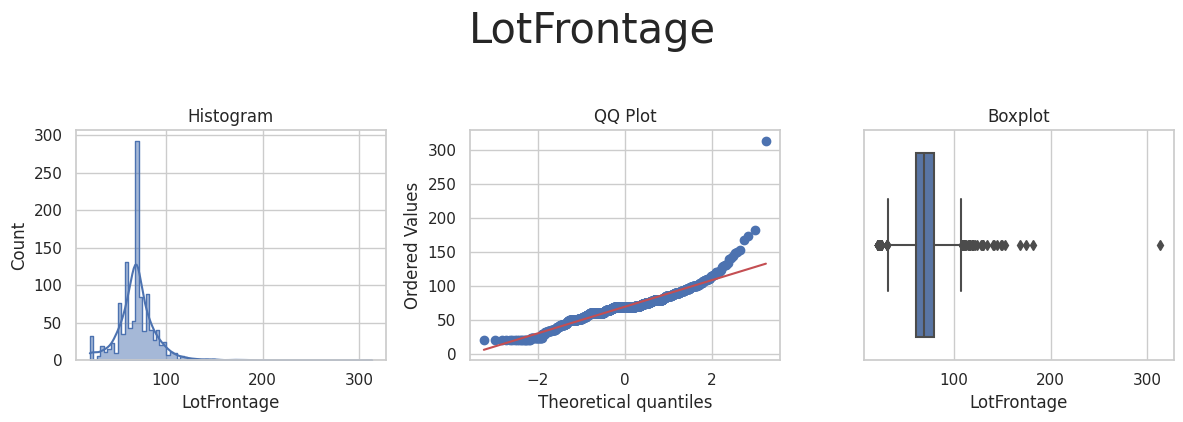

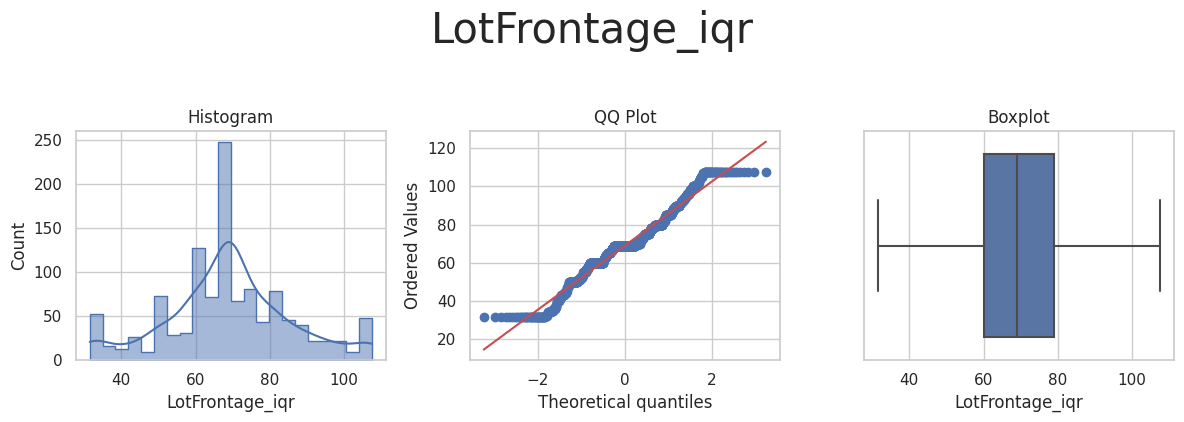



* Variable Analysed: MasVnrArea
* Transformation Applied: ['MasVnrArea_iqr'] 



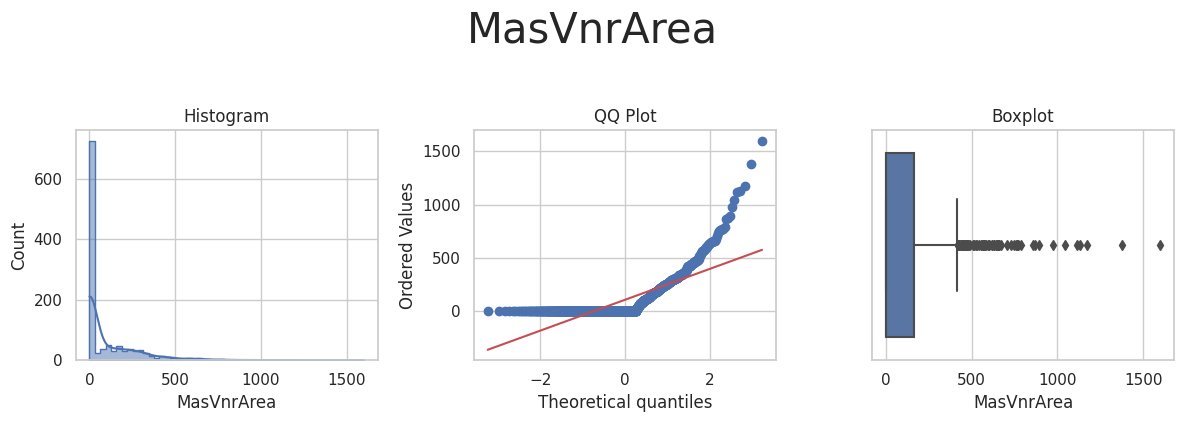

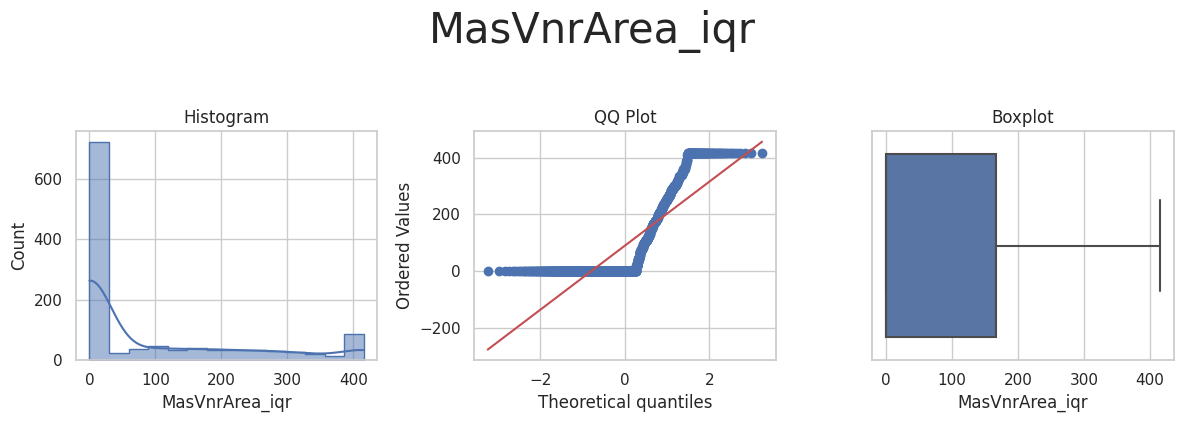



* Variable Analysed: OpenPorchSF
* Transformation Applied: ['OpenPorchSF_iqr'] 



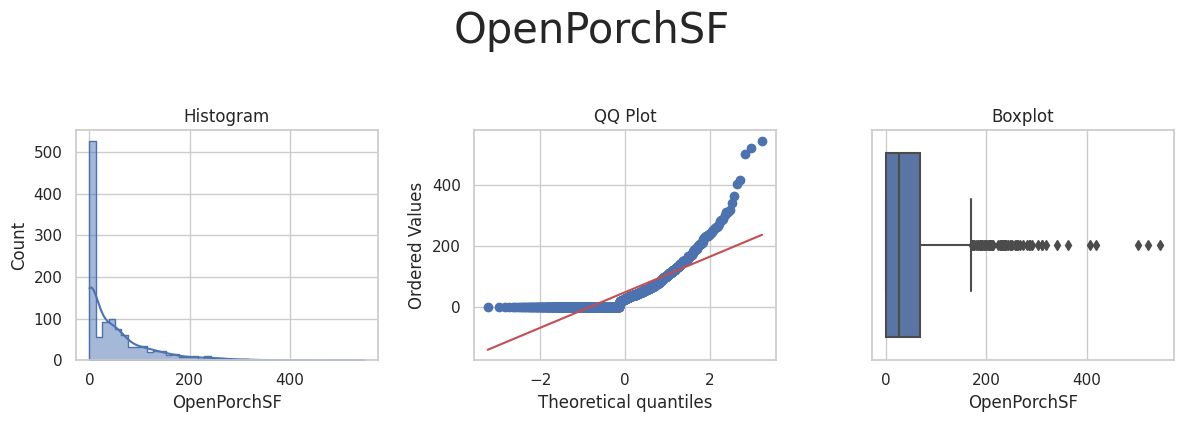

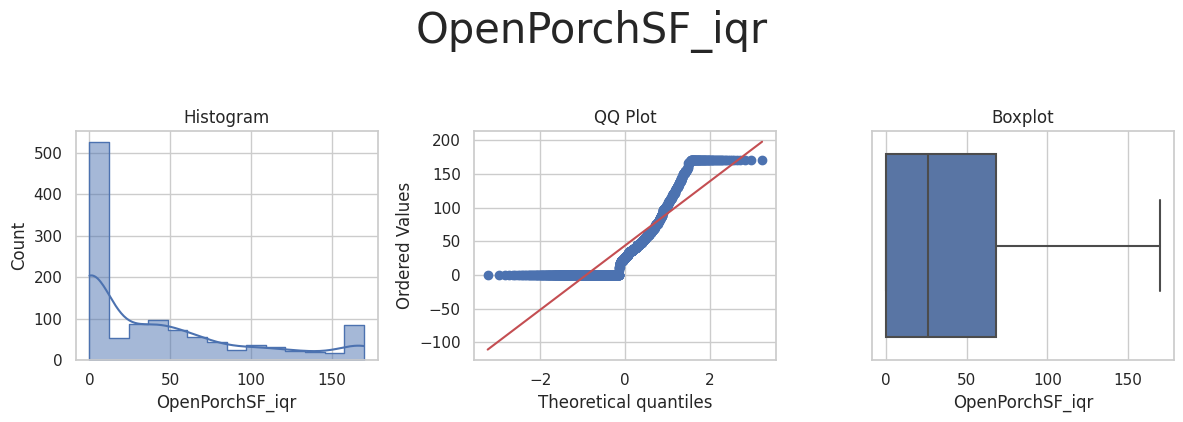



* Variable Analysed: OverallCond
* Transformation Applied: ['OverallCond_iqr'] 



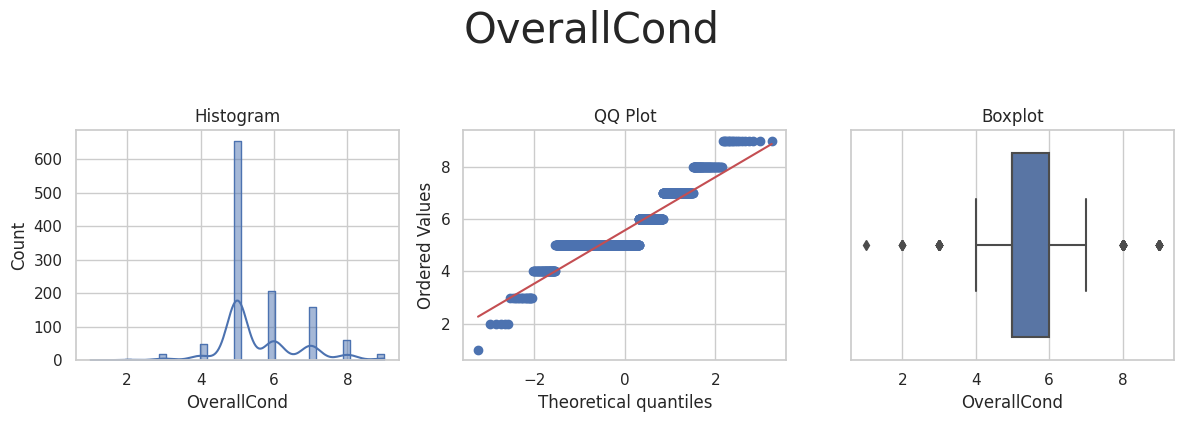

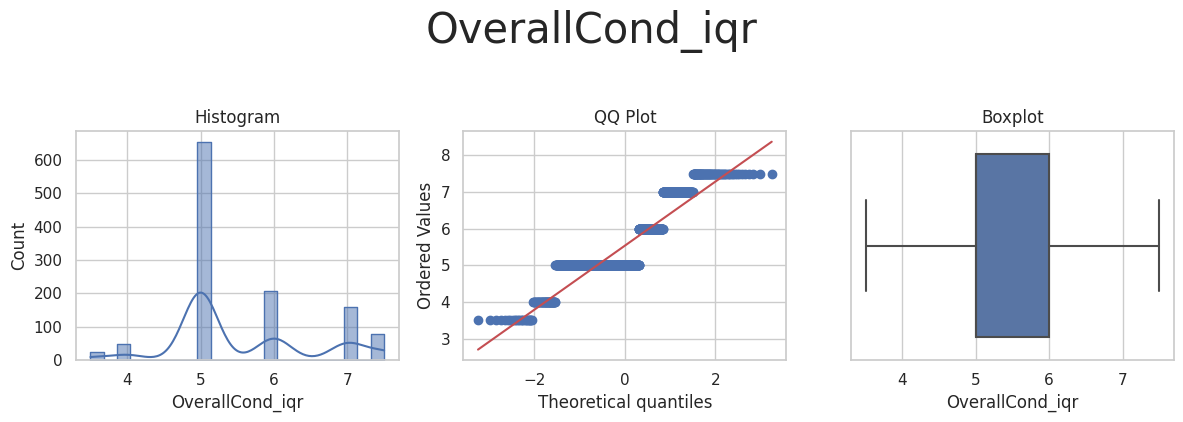



* Variable Analysed: OverallQual
* Transformation Applied: ['OverallQual_iqr'] 



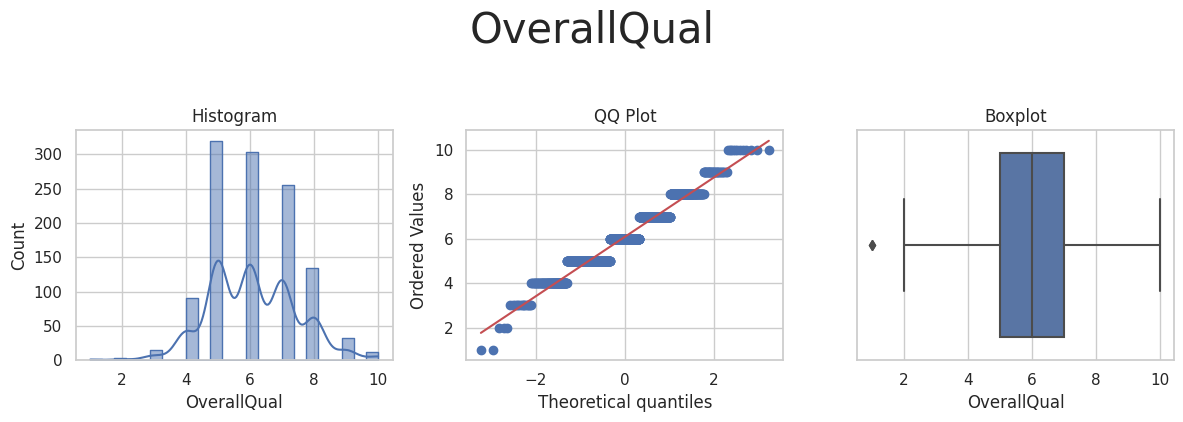

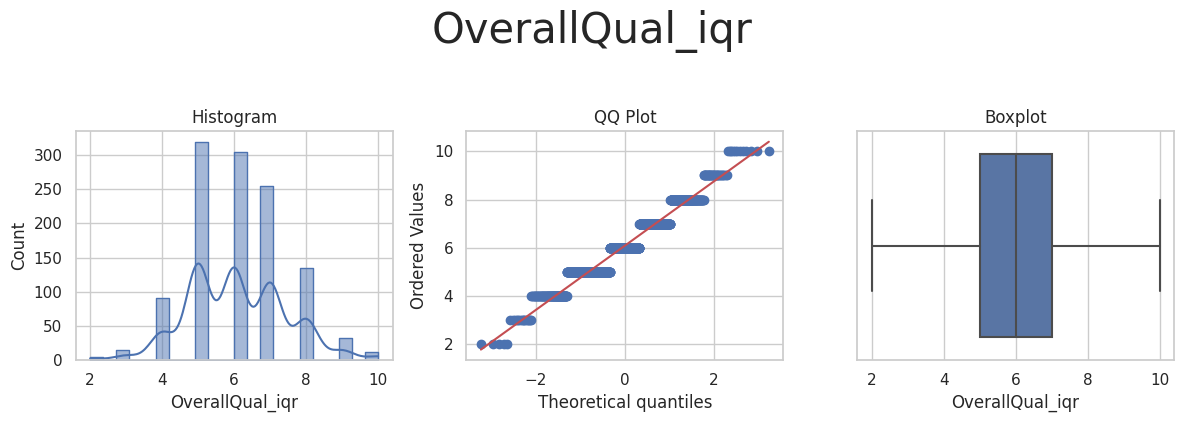



* Variable Analysed: TotalBsmtSF
* Transformation Applied: ['TotalBsmtSF_iqr'] 



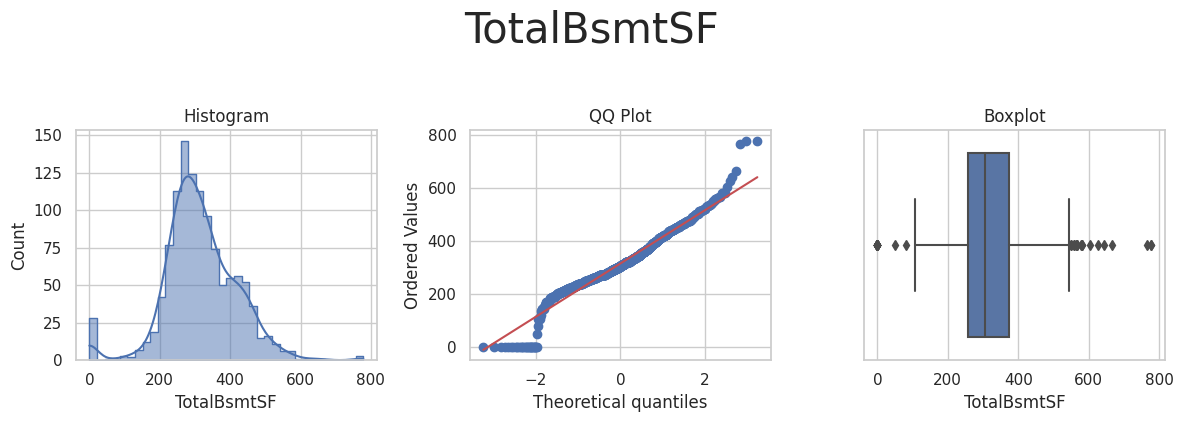

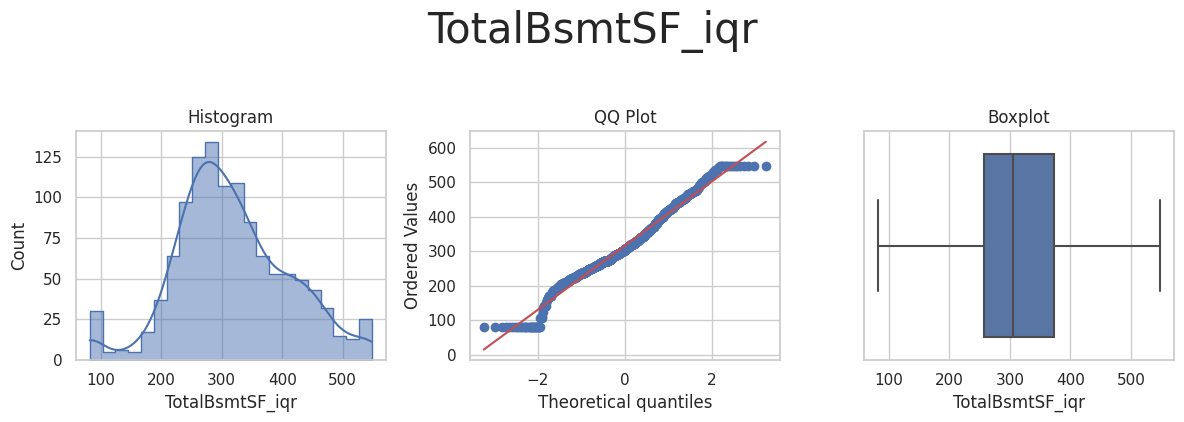



* Variable Analysed: YearBuilt
* Transformation Applied: ['YearBuilt_iqr'] 



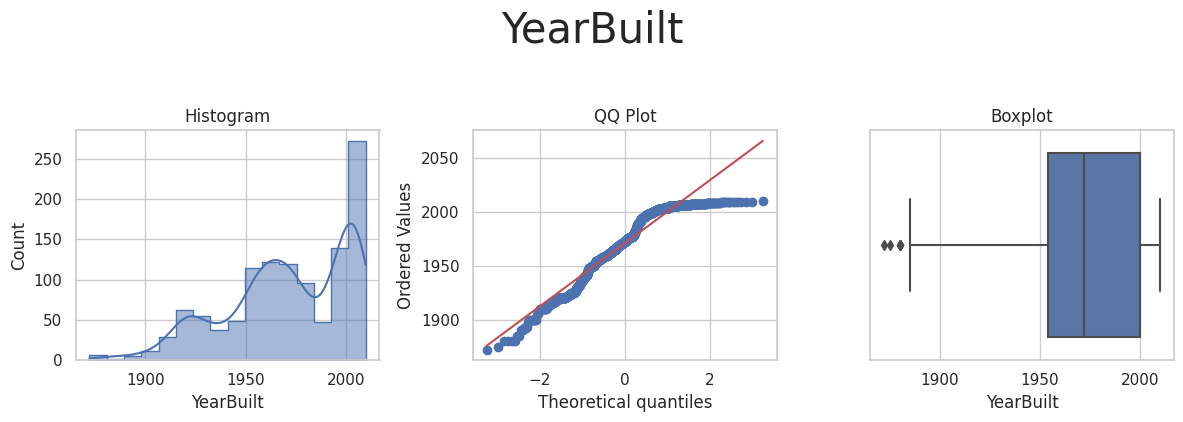

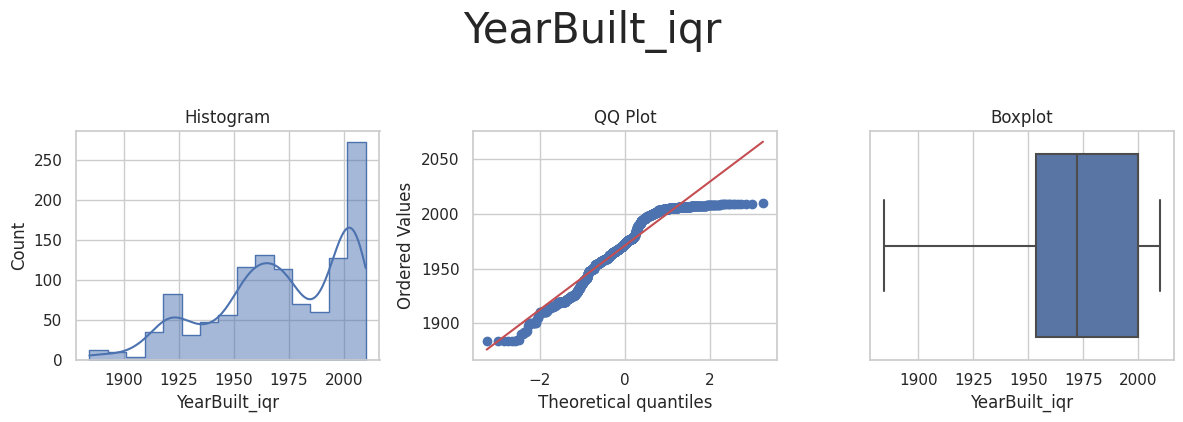



* Variable Analysed: YearRemodAdd
* Transformation Applied: ['YearRemodAdd_iqr'] 



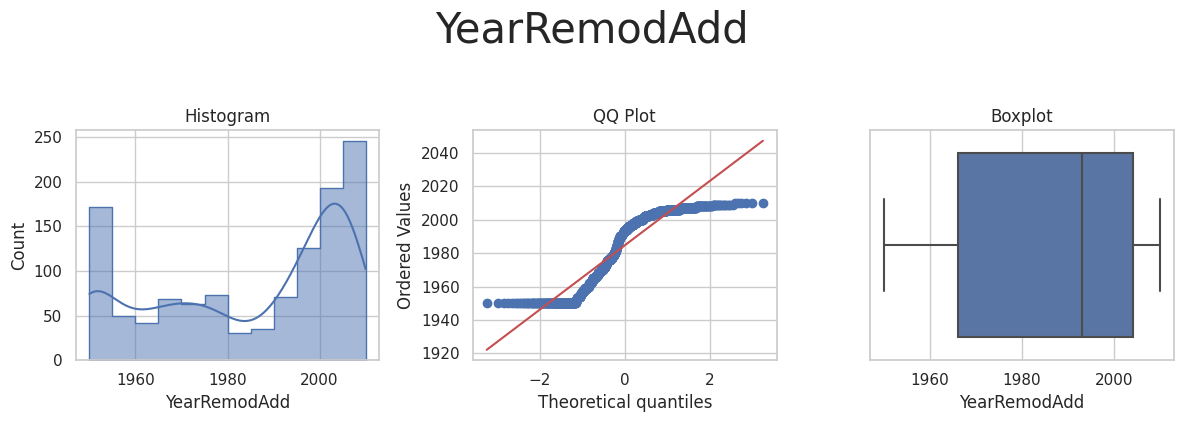

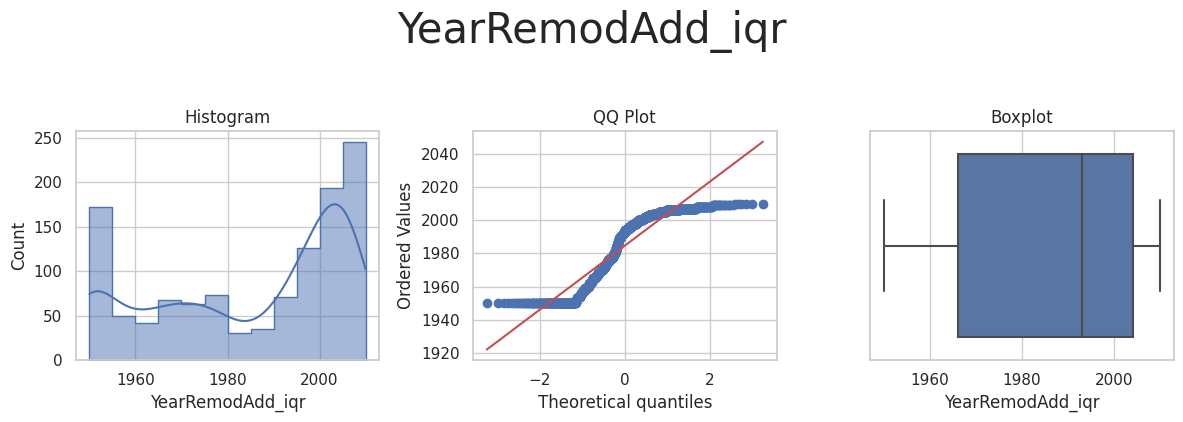



* Variable Analysed: SalePrice
* Transformation Applied: ['SalePrice_iqr'] 



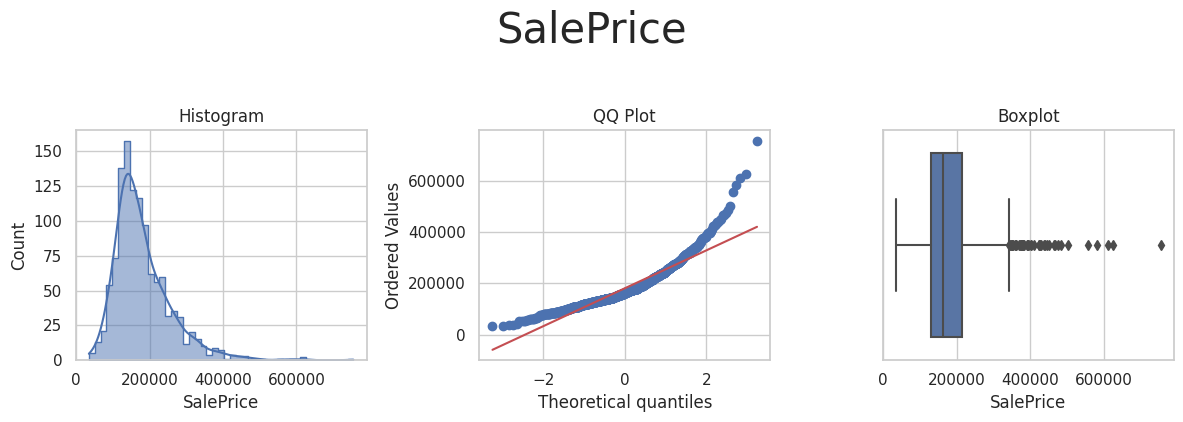

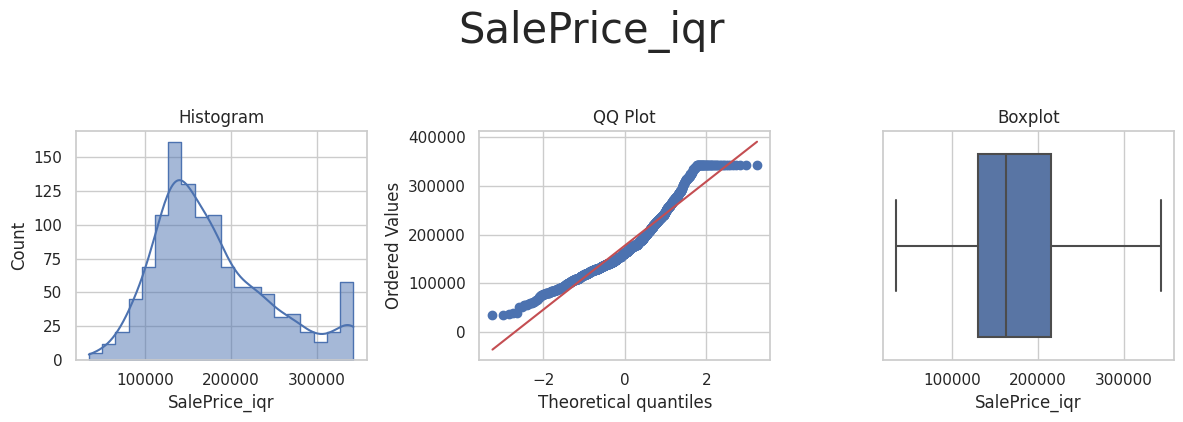

In [21]:
df_engineering = FeatureEngineeringAnalysis(df=df_engineering, analysis_type='outlier_winsorizer')

### Conclusion

* The only variable that would benefit from the removal of outliers would be 'GrLivArea'. Based on the values in the inherited houses, we would benefit from having the other outliers present.


Step 4: Apply the selected transformation to the Train and Test set

In [24]:
from sklearn.pipeline import Pipeline

variables_engineering = ['GrLivArea']

pipeline = Pipeline([
    ('winsorizer', Winsorizer(capping_method='iqr', tail='both', fold=1.5, variables=variables_engineering)),
])

TrainSet = pipeline.fit_transform(TrainSet)
TestSet = pipeline.transform(TestSet)

print("* Outlier transformations done!")

AttributeError: 'Pipeline' object has no attribute 'trainsform'

## Smart Correlated Selection

The steps we will use for each will be as follows:
* Step 1: Select variables
* Step 2: Create separate DataFrame
* Step 3: Create engineered variable applying the transformations, assess the variables distribution and select suitable method
* Step 4: Apply the selected transformation to the Train and Test set